# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
!pip install PyDrive
!pip install keras==2.2.4
!pip install tensorflow==1.13.1
!pip install git+https://github.com/darecophoenixx/wordroid.sblo.jp

  Cloning https://github.com/darecophoenixx/wordroid.sblo.jp to /tmp/pip-req-build-bzp81781
  Running command git clone -q https://github.com/darecophoenixx/wordroid.sblo.jp /tmp/pip-req-build-bzp81781
  Created wheel for wordroid.sblo.jp: filename=wordroid.sblo.jp-0.0.1-cp36-none-any.whl size=33710 sha256=9415e8c72c7ef2e2c79747310547b75d25491e7a523d091179f187e4a8160ffe
  Stored in directory: /tmp/pip-ephem-wheel-cache-29lds_un/wheels/3d/6d/24/44e7d6dc47b39e74772a04beb27433ba2ebed90876394cda60
Successfully built wordroid.sblo.jp


In [2]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,self.imsize)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.8)*diff + (-0.2)*euclidean(individual-self.img.reshape(1,self.imsize))/self.imsize 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(self.imsize)-self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,self.imsize)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"16oao6c9BTb33sbaFzCDJ1sGQn4Z0ILS7"}) 
downloaded.GetContentFile('rbfnn_v2.h5')   

num_lm0 = 100
num_lm = num_lm0 * 10
init_wgt = np.zeros(((1000, 784)))

inp = Input(shape=(28*28,), name='inp')
oup = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp)
oup = Dense(10, activation='softmax')(oup)
model = Model(inp, oup)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("rbfnn_v2.h5")

Instructions for updating:
Colocations handled automatically by placer.


# Prepare Data

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
def prepare_data(X,y):
  X = X.reshape((X.shape[0], -1))
  X_sc = X / 255.0
  y_cat = to_categorical(y)
  return X_sc, y_cat

In [9]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_sc = X_train / 255.0
X_sc.shape
y_cat = to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0
y_pred_test = model.predict(X_test_sc)
y_pred_train = model.predict(X_sc)
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.93305
Test accuracy:  0.9297


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,28,1,5,10,10000)

In [12]:
subsample.shape

(1021, 784)

In [13]:
subsample_y.shape

(1021,)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(subsample_sc)

In [15]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.9333986287952988


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)

In [17]:
original.shape

(895, 784)

In [18]:
adversarial.shape

(126, 784)

In [19]:
adversarial_y.shape

(126,)

In [0]:
import pickle
file_ = open('subset', 'wb')
pickle.dump(original, file_)
pickle.dump(adversarial, file_)
pickle.dump(original_y, file_)
pickle.dump(adversarial_y, file_)
file_.close()


# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 20, #50 (5) #200 (1)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2) (it was 2000)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4) (it was 125)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  0.015810264311457045 25
50  :  0.1604522353456901 25
75  :  0.1732458055918744 25
100  :  0.07505433061496924 25
125  :  0.15949495075222336 25
150  :  0.1300979661259425 25
175  :  0.16417434198646985 25
200  :  0.21843022934362266 25
225  :  0.22748980276176 25
250  :  0.2665882950260434 25
275  :  0.2721006921094591 25
300  :  0.2785913961753159 25
325  :  0.2847977855421197 25
350  :  0.2847977855421197 25
375  :  0.2847977855421197 25
400  :  0.2904691376016212 25
425  :  0.2904691376016212 25
450  :  0.2942184148269703 25
475  :  0.29724234926830967 25
500  :  0.29724234926830967 25
525  :  0.29724234926830967 25
550  :  0.30093429216019024 25
575  :  0.30595787049161927 25
600  :  0.30993383117752604 25
625  :  0.3110657682856072 25
650  :  0.3139243473886254 25
675  :  0.31392590183912 25
700  :  0.3152088802997913 25
725  :  0.3171283182940409 25
750  :  0.3194952922331129 25
775  :  0.3213205887604295 25
800  :  0.3229192075152126 25
825  :  0.32295080935319026 25
850 

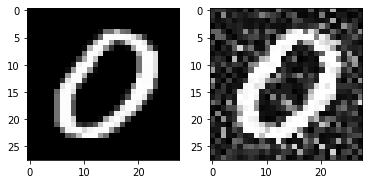

25  :  -0.0474122885290697 25
50  :  0.1179415602081848 25
75  :  0.08856558577975271 25
100  :  0.11725286270543644 25
125  :  0.11480463108812222 25
150  :  0.1441969165514636 25
175  :  0.12949877380270103 25
200  :  0.1501519620032341 25
225  :  0.1885832566693345 25
250  :  0.2016162935625916 25
275  :  0.23996352803642085 25
300  :  0.2430094001522879 25
325  :  0.2471523900607261 25
350  :  0.2536471378882501 25
375  :  0.2764689918905553 25
400  :  0.2755585523059343 25
425  :  0.28877855306827044 25
450  :  0.28892024596192867 25
475  :  0.28892024596192867 25
500  :  0.2941689132822601 25
525  :  0.29858942714019177 25
550  :  0.3032485675336129 25
575  :  0.3041557032928367 25
600  :  0.30885842026449994 25
625  :  0.3094885395143982 25
650  :  0.31093456866828206 25
675  :  0.31565276373953927 25
700  :  0.3236347887272757 25
725  :  0.3236347887272757 25
750  :  0.3236347887272757 25
775  :  0.3243460272147485 25
800  :  0.32491658828854353 25
825  :  0.32814760837702084 2

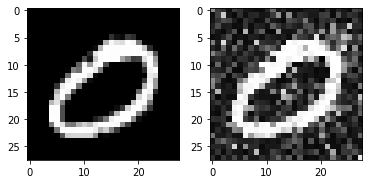

25  :  0.055713143935767984 25
50  :  0.055713143935767984 25
75  :  0.06434614265878363 25
100  :  0.11070568023356742 25
125  :  0.07913030164122525 25
150  :  0.11512195001972825 25
175  :  0.1898678965134427 25
200  :  0.21817784634115833 25
225  :  0.22877215420220254 25
250  :  0.23116239864709065 25
275  :  0.23116239864709065 25
300  :  0.2314838999788673 25
325  :  0.23190345061777118 25
350  :  0.25082932829480475 25
375  :  0.2510960997629358 25
400  :  0.2558860679964785 25
425  :  0.26647576075982804 25
450  :  0.26599927361688575 25
475  :  0.2672761105575278 25
500  :  0.2752438960727078 25
525  :  0.2770240866474693 25
550  :  0.2796064875057676 25
575  :  0.28307182757248583 25
600  :  0.28307182757248583 25
625  :  0.28550315609841975 25
650  :  0.28553163467602194 25
675  :  0.28741713148754383 25
700  :  0.2880952464307858 25
725  :  0.2883770826886844 25
750  :  0.2899314590433576 25
775  :  0.2913569023515559 25
800  :  0.29171433540124697 25
825  :  0.29353830006

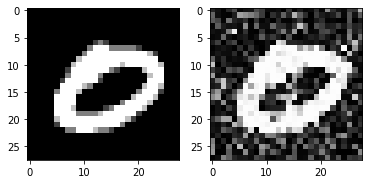

25  :  -0.6718702327437953 25
50  :  -0.03555872552880246 25
75  :  -0.2443127036118144 25
100  :  -0.3774371320577341 25
125  :  -0.34576973893035334 25
150  :  -0.4660016483871744 25
175  :  -0.8720178623528847 25
200  :  -0.8704102933242481 25
225  :  -0.8704434336458466 25
250  :  -0.8673648893321915 25
275  :  -0.8649630903749224 25
300  :  -0.8643505150443925 25
325  :  -0.8643505150443925 25
350  :  -0.8630443198370149 25
375  :  -0.8627234913207166 25
400  :  -0.8603047938710391 25
425  :  -0.8585209244454358 25
450  :  -0.8569921707171275 25
475  :  -0.8381759348155856 25
500  :  -0.7999789090610112 25
525  :  -0.6877565627479085 25
550  :  -0.6254629480792173 25
575  :  0.13595856394001576 25
600  :  0.36426392461564466 25
625  :  0.35980515050581785 25
650  :  0.3647604958185088 25
675  :  0.39148971162377433 25
700  :  0.39077676419511764 25
725  :  0.39077676419511764 25
750  :  0.3982897356131174 25
775  :  0.4059327698761082 25
800  :  0.40770330571363256 25
825  :  0.41

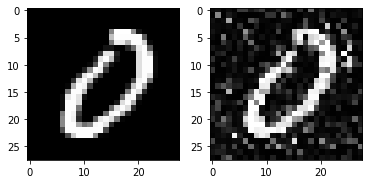

25  :  0.379592084146105 25
50  :  0.379592084146105 25
75  :  0.289946547199335 25
100  :  0.35572790464072207 25
125  :  0.3867450768449262 25
150  :  0.39075524226947284 25
175  :  0.3993333466020573 25
200  :  0.41362533163426274 25
225  :  0.41362533163426274 25
250  :  0.422942191513922 25
275  :  0.433275450754022 25
300  :  0.4374089052187865 25
325  :  0.43750839292312593 25
350  :  0.4412113434345411 25
375  :  0.44588480574222966 25
400  :  0.4513278625797277 25
425  :  0.4659766659399938 25
450  :  0.46677306708649097 25
475  :  0.46965323463514536 25
500  :  0.470593732263501 25
525  :  0.47579375063050305 25
550  :  0.47779398765124786 25
575  :  0.47841363500299167 25
600  :  0.47966518605185854 25
625  :  0.47978724414080665 25
650  :  0.4806862075924585 25
675  :  0.4839255920149202 25
700  :  0.48570723114632824 25
725  :  0.489355044526498 25
750  :  0.4893553959187938 25
775  :  0.4927581794126408 25
800  :  0.4927377087648081 25
825  :  0.4930011095532345 25
850  :

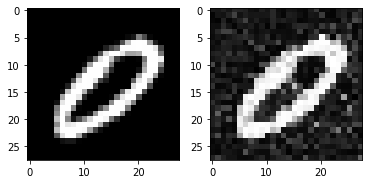

25  :  0.326643119700723 25
50  :  0.3348532682525459 25
75  :  0.34986972025322827 25
100  :  0.358293315412098 25
125  :  0.369459524899206 25
150  :  0.35470411175562017 25
175  :  0.3979023396763856 25
200  :  0.4179939643119743 25
225  :  0.41819985673809024 25
250  :  0.41819985673809024 25
275  :  0.4250456699163351 25
300  :  0.42700889036933876 25
325  :  0.43899819494891 25
350  :  0.4496525238384296 25
375  :  0.44892376151221663 25
400  :  0.45096781597705604 25
425  :  0.46055547523824225 25
450  :  0.47121354596004544 25
475  :  0.47342159567177294 25
500  :  0.47742834541368806 25
525  :  0.48050881723378114 25
550  :  0.4809212268752549 25
575  :  0.48201750037528845 25
600  :  0.48244070877237316 25
625  :  0.48244070877237316 25
650  :  0.48244070877237316 25
675  :  0.4844045247390544 25
700  :  0.4845238600358033 25
725  :  0.4853971456955579 25
750  :  0.48871163479145424 25
775  :  0.4886673998784496 25
800  :  0.4886673998784496 25
825  :  0.4902367309299031 25
8

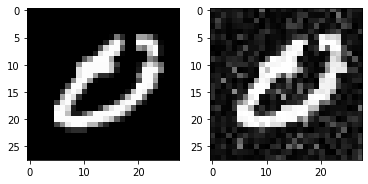

25  :  -0.5758764320763399 25
50  :  -0.44327964906825923 25
75  :  -0.8933759885710646 25
100  :  -0.8933759885710646 25
125  :  -0.8843299331608302 25
150  :  -0.8842550922090026 25
175  :  -0.8842550922090026 25
200  :  -0.8834358123278678 25
225  :  -0.8827842582775437 25
250  :  -0.8769776446747545 25
275  :  -0.8769776446747545 25
300  :  -0.8747191670103014 25
325  :  -0.8744457263046611 25
350  :  -0.8744130499185014 25
375  :  -0.8736248313574881 25
400  :  -0.8735206645286694 25
425  :  -0.8726722023910639 25
450  :  -0.8716755119578329 25
475  :  -0.8702138632148048 25
500  :  -0.8679579761613796 25
525  :  -0.8676739191180357 25
550  :  -0.8676739191180357 25
575  :  -0.8669277162166485 25
600  :  -0.8668479584462724 25
625  :  -0.8668479504006085 25
650  :  -0.8660412712292469 25
675  :  -0.8648862705438491 25
700  :  -0.864627644309341 25
725  :  -0.862960038388284 25
750  :  -0.862960038388284 25
775  :  -0.862960038388284 25
800  :  -0.8625954178099132 25
825  :  -0.862

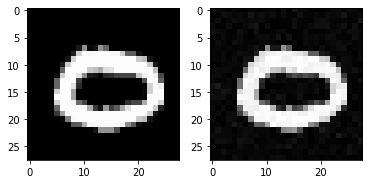

25  :  -0.8939292617664786 25
50  :  -0.8908300513021296 25
75  :  -0.8816490564770166 25
100  :  -0.877656975034571 25
125  :  -0.8744499002000239 25
150  :  -0.8743742157169389 25
175  :  -0.8707859058137853 25
200  :  -0.8707859058137853 25
225  :  -0.8707859058137853 25
250  :  -0.8707859058137853 25
275  :  -0.8707859058137853 25
300  :  -0.8691344141223019 25
325  :  -0.8691344141223019 25
350  :  -0.8671572454491188 25
375  :  -0.866964415446163 25
400  :  -0.8647034241597775 25
425  :  -0.861994858068076 25
450  :  -0.861994858068076 25
475  :  -0.861994858068076 25
500  :  -0.861994858068076 25
525  :  -0.861994858068076 25
550  :  -0.8617060167177475 25
575  :  -0.8616853915415462 25
600  :  -0.8615885201697662 25
625  :  -0.8615885201697662 25
650  :  -0.8612408925526972 25
675  :  -0.8609406100753474 25
700  :  -0.8609406100753474 25
725  :  -0.8608927985379676 25
750  :  -0.8608927985379676 25
775  :  -0.8606810278776205 25
800  :  -0.8606810278776205 25
Time:  90.20916557

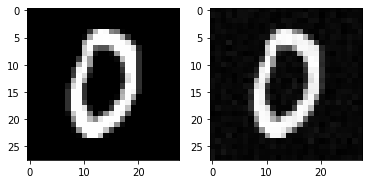

25  :  -0.4278603790628895 25
50  :  -0.01001990109302553 25
75  :  -0.38835393704735094 25
100  :  -0.040219473642723214 25
125  :  0.017969337112212602 25
150  :  0.08857877981579643 25
175  :  0.11495191755574524 25
200  :  0.1481396728550537 25
225  :  0.151859235007046 25
250  :  0.1816892891661538 25
275  :  0.20299766583276202 25
300  :  0.2057818162538676 25
325  :  0.2057818162538676 25
350  :  0.2057818162538676 25
375  :  0.2057818162538676 25
400  :  0.21390792235865586 25
425  :  0.21390792235865586 25
450  :  0.22349854250849133 25
475  :  0.22139185284213947 25
500  :  0.22407558671802708 25
525  :  0.22688505610837473 25
550  :  0.23050962977405653 25
575  :  0.233050024815588 25
600  :  0.24437470936775085 25
625  :  0.24922192124793607 25
650  :  0.2508789582963702 25
675  :  0.2508789582963702 25
700  :  0.2616531010953528 25
725  :  0.2610879744201785 25
750  :  0.26990867019380654 25
775  :  0.2716132420384013 25
800  :  0.27326569820211827 25
825  :  0.27327750728

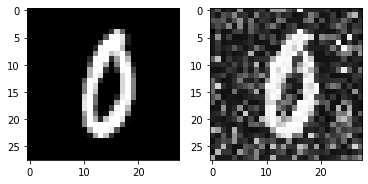

25  :  -0.5261849211310703 25
50  :  -0.1178542246392017 25
75  :  -0.24030740760069336 25
100  :  -0.3248927590604423 25
125  :  -0.23457286964297008 25
150  :  -0.8857247509781716 25
175  :  -0.8857247509781716 25
200  :  -0.8857247509781716 25
225  :  -0.8857247509781716 25
250  :  -0.8857247509781716 25
275  :  -0.8799117350971032 25
300  :  -0.8799117350971032 25
325  :  -0.8721311001117729 25
350  :  -0.872080311823241 25
375  :  -0.872080311823241 25
400  :  -0.872080311823241 25
425  :  -0.872080311823241 25
450  :  -0.8720527515054207 25
475  :  -0.8720527515054207 25
500  :  -0.8719623559676939 25
525  :  -0.8688579075646353 25
550  :  -0.8683360915073993 25
575  :  -0.8671319357106624 25
600  :  -0.8669711354601628 25
625  :  -0.8662509819917472 25
650  :  -0.8656861165325564 25
675  :  -0.8656856865953034 25
700  :  -0.8648623405278679 25
725  :  -0.8647810728508594 25
750  :  -0.8644235554185649 25
775  :  -0.8644219192485094 25
800  :  -0.864246324796475 25
825  :  -0.864

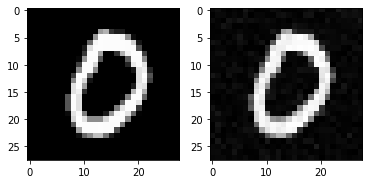

25  :  0.5302703674534598 25
50  :  0.5413856758764817 25
75  :  0.5237399775346854 25
100  :  0.5506707186365427 25
125  :  0.5368494124408895 25
150  :  0.5501737694374844 25
175  :  0.5599944439676776 25
200  :  0.5591640862493055 25
225  :  0.5712072622095244 25
250  :  0.5765151234625763 25
275  :  0.5824383990901604 25
300  :  0.5873550328078658 25
325  :  0.5919283255457441 25
350  :  0.5937807082761605 25
375  :  0.5937807082761605 25
400  :  0.59501818897343 25
425  :  0.595986576124068 25
450  :  0.6036936545348892 25
475  :  0.6085957317747844 25
500  :  0.6083810432012805 25
525  :  0.6102318043359356 25
550  :  0.6110767493711112 25
575  :  0.6111915363107 25
600  :  0.6129692456106004 25
625  :  0.615306293119418 25
650  :  0.6156168846369838 25
675  :  0.6156486026591448 25
700  :  0.6170208079184776 25
725  :  0.6207869810238902 25
750  :  0.6207263640142366 25
775  :  0.6215276219747061 25
800  :  0.6231865335328082 25
825  :  0.6231865335328082 25
850  :  0.6233346889

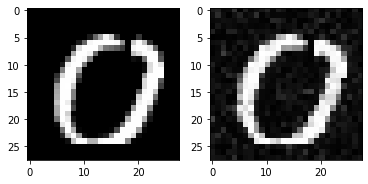

25  :  -0.3901730383441566 25
50  :  -0.09305648095626073 25
75  :  -0.31268933673482646 25
100  :  -0.8852108801107583 25
125  :  -0.06773431875477609 25
150  :  -0.3151910159090195 25
175  :  -0.8761847866582839 25
200  :  -0.8761847866582839 25
225  :  -0.8761847866582839 25
250  :  -0.8735746622240477 25
275  :  -0.8670063481718178 25
300  :  -0.8670063481718178 25
325  :  -0.8655747075002134 25
350  :  -0.865200378216498 25
375  :  -0.8646225408272152 25
400  :  -0.8623864931788399 25
425  :  -0.8616042362186304 25
450  :  -0.861604225874272 25
475  :  -0.861604225874272 25
500  :  -0.861298888337299 25
525  :  -0.8599040778181041 25
550  :  -0.8599040778181041 25
575  :  -0.8599040778181041 25
600  :  -0.8599040778181041 25
625  :  -0.8589927137319371 25
650  :  -0.8589927137319371 25
675  :  -0.8589927137319371 25
700  :  -0.8584931942795462 25
725  :  -0.8583671209047248 25
750  :  -0.8583671209047248 25
775  :  -0.8583425855972708 25
800  :  -0.8583425855972708 25
825  :  -0.8

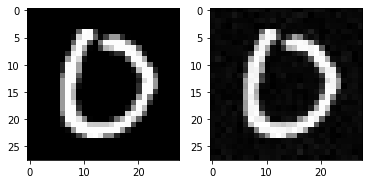

25  :  0.6442066269267405 25
50  :  0.6442066269267405 25
75  :  0.6486750012391945 25
100  :  0.6484961387310427 25
125  :  0.6561433021406899 25
150  :  0.6558221638794737 25
175  :  0.6558221638794737 25
200  :  0.6588346263988203 25
225  :  0.6624244728677616 25
250  :  0.668653330682373 25
275  :  0.6688765083090872 25
300  :  0.6698378145249451 25
325  :  0.6737463292780426 25
350  :  0.6737463292780426 25
375  :  0.6762036878384091 25
400  :  0.6760147197251881 25
425  :  0.6760147197251881 25
450  :  0.6762797696156588 25
475  :  0.681517964356357 25
500  :  0.6813579481514818 25
525  :  0.6831149482876011 25
550  :  0.6833539411216952 25
575  :  0.6834651404870392 25
600  :  0.6835227297594252 25
625  :  0.6835228439945675 25
650  :  0.6849438480193422 25
675  :  0.6849438480193422 25
700  :  0.6855879218449269 25
725  :  0.6862853240876722 25
750  :  0.6864161277719029 25
775  :  0.6864161277719029 25
800  :  0.686517500995128 25
Time:  94.24030041694641  seconds
Predicted cl

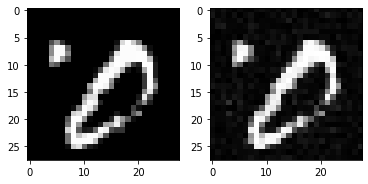

25  :  -0.7362056317443051 25
50  :  -0.7101560138200969 25
75  :  -0.619443089995362 25
100  :  -0.3089184007530257 25
125  :  0.27308795141474473 25
150  :  0.3305813535404639 25
175  :  0.43274566188664587 25
200  :  0.43274566188664587 25
225  :  0.4382685764427244 25
250  :  0.45355004923954245 25
275  :  0.4551602338721694 25
300  :  0.4574381856524594 25
325  :  0.46352137420379547 25
350  :  0.4695323668546676 25
375  :  0.4752734887099895 25
400  :  0.476522167732386 25
425  :  0.4775695256700373 25
450  :  0.4874481968707502 25
475  :  0.4965921010680431 25
500  :  0.4965921010680431 25
525  :  0.4965921010680431 25
550  :  0.4965921010680431 25
575  :  0.5027576511083922 25
600  :  0.502770332281973 25
625  :  0.5057293111735233 25
650  :  0.505763925341832 25
675  :  0.505763925341832 25
700  :  0.5087669710694689 25
725  :  0.5087669710694689 25
750  :  0.5106553878479281 25
775  :  0.5128690696938387 25
800  :  0.5128690696938387 25
825  :  0.5136948743180666 25
850  :  0

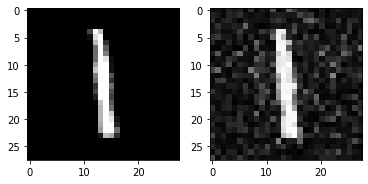

25  :  -0.8831450473753282 25
50  :  -0.8788383053010026 25
75  :  -0.8783251529705833 25
100  :  -0.8735029782600887 25
125  :  -0.8707626564503279 25
150  :  -0.8644939884986151 25
175  :  -0.8615529235712436 25
200  :  -0.8465548015196815 25
225  :  -0.8429151613715857 25
250  :  -0.6848882122830252 25
275  :  -0.5630826543615445 25
300  :  0.06330416085835311 25
325  :  0.3048189841870969 25
350  :  0.30132540278566133 25
375  :  0.36417390771422187 25
400  :  0.3658047400518516 25
425  :  0.3658047400518516 25
450  :  0.3781587318309203 25
475  :  0.42504145119639103 25
500  :  0.43028598578722915 25
525  :  0.4534506494737302 25
550  :  0.4534506494737302 25
575  :  0.4534506494737302 25
600  :  0.4534506494737302 25
625  :  0.4553096814677932 25
650  :  0.4604276462219417 25
675  :  0.46177682153109967 25
700  :  0.46552606476899433 25
725  :  0.4849043791590039 25
750  :  0.4849043791590039 25
775  :  0.4849043791590039 25
800  :  0.4849043791590039 25
825  :  0.484904379159003

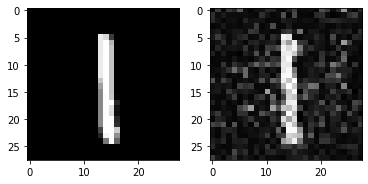

25  :  -0.7523757665025899 25
50  :  -0.44007803771761966 25
75  :  -0.04273552727591973 25
100  :  0.15145302880998884 25
125  :  0.36682339740177117 25
150  :  0.4377324131750351 25
175  :  0.4377324131750351 25
200  :  0.4447967978621571 25
225  :  0.4447967978621571 25
250  :  0.46134381626827486 25
275  :  0.46612937079410366 25
300  :  0.47133482886313355 25
325  :  0.47133482886313355 25
350  :  0.47133482886313355 25
375  :  0.48705647259340373 25
400  :  0.48705647259340373 25
425  :  0.48744136174705277 25
450  :  0.48744136174705277 25
475  :  0.48744136174705277 25
500  :  0.48744136174705277 25
525  :  0.48744136174705277 25
550  :  0.48744136174705277 25
575  :  0.48927443747873206 25
600  :  0.48927443747873206 25
625  :  0.4930091512364207 25
650  :  0.49314197220001743 25
675  :  0.49747639183500564 25
700  :  0.49747639183500564 25
725  :  0.4983370549118241 25
750  :  0.4993407073998615 25
775  :  0.5006209592508899 25
800  :  0.5006216482308252 25
825  :  0.50142195

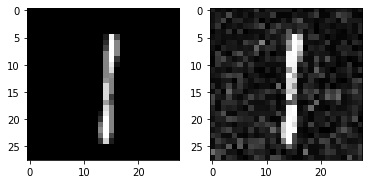

25  :  -0.8933535806416278 25
50  :  -0.8892968300916109 25
75  :  -0.8892968300916109 25
100  :  -0.8892968300916109 25
125  :  -0.8845261213313067 25
150  :  -0.8804292623237145 25
175  :  -0.880182043011184 25
200  :  -0.880182043011184 25
225  :  -0.8778962884828234 25
250  :  -0.8751441844427453 25
275  :  -0.874061427683788 25
300  :  -0.873235167363143 25
325  :  -0.8706638739676917 25
350  :  -0.8706578461431034 25
375  :  -0.8696280697055233 25
400  :  -0.8693793884008592 25
425  :  -0.8693716867522909 25
450  :  -0.868417585733619 25
475  :  -0.8683335832263919 25
500  :  -0.8682660380927321 25
525  :  -0.8680330359756813 25
550  :  -0.8680044967015594 25
575  :  -0.867231376391121 25
600  :  -0.8668022168682028 25
625  :  -0.8668022168682028 25
650  :  -0.8668022168682028 25
675  :  -0.8665290659972147 25
700  :  -0.8664341046291378 25
725  :  -0.8664334018730258 25
750  :  -0.8661606674155321 25
775  :  -0.8659945442511562 25
800  :  -0.8657067347697674 25
Time:  95.2227814

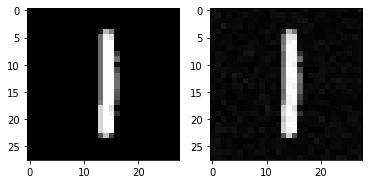

25  :  -0.5296773167348511 25
50  :  -0.5296773167348511 25
75  :  -0.5541338829490533 25
100  :  -0.2434763001235578 25
125  :  0.1209117490883092 25
150  :  0.2711669738658912 25
175  :  0.3042847099580413 25
200  :  0.36998622934453457 25
225  :  0.38691568403796595 25
250  :  0.4150582376886562 25
275  :  0.41692957797201813 25
300  :  0.4610326587153031 25
325  :  0.4609488725893654 25
350  :  0.4609488725893654 25
375  :  0.47038648692084495 25
400  :  0.49147863513972273 25
425  :  0.4928667825072263 25
450  :  0.4978113727173614 25
475  :  0.4978113727173614 25
500  :  0.5104180707373993 25
525  :  0.5168902300829888 25
550  :  0.5168902300829888 25
575  :  0.5168902300829888 25
600  :  0.5168902300829888 25
625  :  0.520137872084602 25
650  :  0.520137872084602 25
675  :  0.5207964560104503 25
700  :  0.5272434164294908 25
725  :  0.530315735510589 25
750  :  0.5303055974866597 25
775  :  0.5312009504922333 25
800  :  0.5332629106143046 25
825  :  0.5351135772761754 25
850  : 

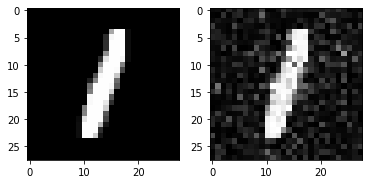

25  :  -0.2113240760806495 25
50  :  -0.01570162345943471 25
75  :  0.11693437306534224 25
100  :  0.2525998158852736 25
125  :  0.3007782527741897 25
150  :  0.3515692098439214 25
175  :  0.356029143978717 25
200  :  0.3878491189573914 25
225  :  0.42366861234023356 25
250  :  0.422182493336938 25
275  :  0.4325287098785516 25
300  :  0.43597112338002275 25
325  :  0.46193773435666724 25
350  :  0.4638751943783802 25
375  :  0.47658710668734827 25
400  :  0.47658710668734827 25
425  :  0.480619560036188 25
450  :  0.48154995525501876 25
475  :  0.48855529651156476 25
500  :  0.49972391856652426 25
525  :  0.5013925940222339 25
550  :  0.5056366276943771 25
575  :  0.5085168595302139 25
600  :  0.5099556639097841 25
625  :  0.5126841938218677 25
650  :  0.5126954030834787 25
675  :  0.5144384314527124 25
700  :  0.5144384314527124 25
725  :  0.5188978159920666 25
750  :  0.5188930903254024 25
775  :  0.5206903456813986 25
800  :  0.5222589016640213 25
825  :  0.5229412203804271 25
850 

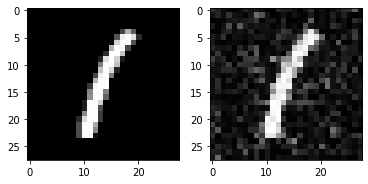

25  :  0.34171709261840894 25
50  :  0.3532840340736867 25
75  :  0.34171709261840894 25
100  :  0.48623103013265934 25
125  :  0.45628357517902907 25
150  :  0.5027879169916568 25
175  :  0.5013870600783156 25
200  :  0.5006621275973079 25
225  :  0.5230279286645654 25
250  :  0.5337463890917813 25
275  :  0.5585267392250277 25
300  :  0.5584818463436054 25
325  :  0.5584818463436054 25
350  :  0.5584818463436054 25
375  :  0.5623186758405074 25
400  :  0.5625543042598791 25
425  :  0.5657784365916768 25
450  :  0.5752521484691693 25
475  :  0.5754367866867397 25
500  :  0.5814694385743124 25
525  :  0.5814694385743124 25
550  :  0.5814694385743124 25
575  :  0.5838841800101869 25
600  :  0.5850181906205525 25
625  :  0.5877435635418354 25
650  :  0.5910772784617129 25
675  :  0.5910978572846182 25
700  :  0.5936943404934849 25
725  :  0.5939080087224657 25
750  :  0.5972891767614688 25
775  :  0.596222136113361 25
800  :  0.5966145256729202 25
825  :  0.5966145256729202 25
850  :  0.

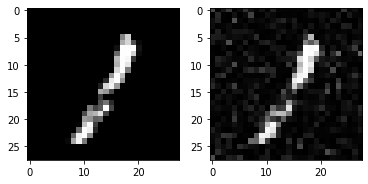

25  :  0.4569525729011042 25
50  :  0.4569525729011042 25
75  :  0.3666858924385114 25
100  :  0.3658358042615473 25
125  :  0.42611376744924434 25
150  :  0.4038645807998466 25
175  :  0.40458600012450774 25
200  :  0.4290715564140292 25
225  :  0.4145070405653827 25
250  :  0.41721615054703465 25
275  :  0.4332200816850069 25
300  :  0.4332200816850069 25
325  :  0.4332200816850069 25
350  :  0.4332200816850069 25
375  :  0.4436808916942557 25
400  :  0.4404343143765169 25
425  :  0.44986919936904174 25
450  :  0.44965113392485623 25
475  :  0.458749408114795 25
500  :  0.45809903064321955 25
525  :  0.45809903064321955 25
550  :  0.460535125603958 25
575  :  0.46309835073578715 25
600  :  0.4794387381310524 25
625  :  0.47830224867933335 25
650  :  0.47830224867933335 25
675  :  0.4826258239050305 25
700  :  0.4826827661471096 25
725  :  0.48434831966060177 25
750  :  0.4847818059519733 25
775  :  0.48747314190170776 25
800  :  0.4874013593052628 25
825  :  0.4874013593052628 25
850

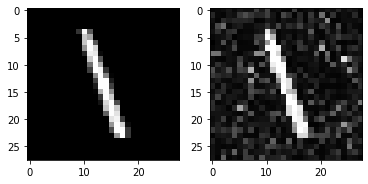

25  :  -0.7984528316170295 25
50  :  -0.7951687544169292 25
75  :  -0.7606655248621186 25
100  :  -0.6451853548914126 25
125  :  -0.5532803247956938 25
150  :  -0.13922508850804519 25
175  :  0.29592252513009615 25
200  :  0.38231170356851135 25
225  :  0.41490042560883855 25
250  :  0.4332608563835132 25
275  :  0.4356763865518736 25
300  :  0.4356763865518736 25
325  :  0.4568243863325817 25
350  :  0.46305715693945676 25
375  :  0.4641778645648459 25
400  :  0.4707822699218961 25
425  :  0.47065785629886653 25
450  :  0.47679158703555335 25
475  :  0.4770414831945456 25
500  :  0.48119110095109907 25
525  :  0.4865416097429636 25
550  :  0.48829312904911376 25
575  :  0.4904353795564461 25
600  :  0.49198894889443046 25
625  :  0.4968521224496043 25
650  :  0.5003999852094123 25
675  :  0.5055577847132151 25
700  :  0.5082265055264897 25
725  :  0.5084990931261414 25
750  :  0.5109525692491299 25
775  :  0.5127492204030155 25
800  :  0.5127475093851523 25
825  :  0.5146664736818138 

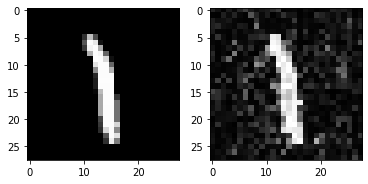

25  :  -0.8880395291071841 25
50  :  -0.8863522008870068 25
75  :  -0.8792698371854621 25
100  :  -0.8789931014168414 25
125  :  -0.8745846954303111 25
150  :  -0.8718519358372216 25
175  :  -0.8718519358372216 25
200  :  -0.8718519358372216 25
225  :  -0.8706568134599327 25
250  :  -0.8693386072593778 25
275  :  -0.8677230980860899 25
300  :  -0.8675847936990442 25
325  :  -0.8661494227547697 25
350  :  -0.8660027831819941 25
375  :  -0.8639434689539551 25
400  :  -0.8639413951386427 25
425  :  -0.8629018670031019 25
450  :  -0.8618372597995062 25
475  :  -0.8614463999139474 25
500  :  -0.8614465901321209 25
525  :  -0.8614465901321209 25
550  :  -0.8613945399744581 25
575  :  -0.8612648037362579 25
600  :  -0.8609372965286065 25
625  :  -0.8609027399626631 25
650  :  -0.8608002739499419 25
675  :  -0.8603799017430207 25
700  :  -0.8603509385525624 25
725  :  -0.8602796195173333 25
750  :  -0.8600952253781218 25
775  :  -0.8598848129500819 25
800  :  -0.8598451261296335 25
Time:  84.6

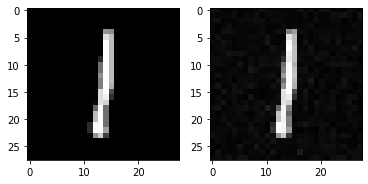

25  :  -0.8789899263494576 25
50  :  -0.8789899263494576 25
75  :  -0.8729667749062004 25
100  :  -0.8729667749062004 25
125  :  -0.8691597932710454 25
150  :  -0.8670078300622752 25
175  :  -0.8620469556809901 25
200  :  -0.8606651590527896 25
225  :  -0.8585841752452412 25
250  :  -0.8563442373935202 25
275  :  -0.8194902220066066 25
300  :  -0.746423062914456 25
325  :  -0.537166661028274 25
350  :  0.17341389469059226 25
375  :  0.34829387180130117 25
400  :  0.3584223720138483 25
425  :  0.3584223720138483 25
450  :  0.401700765181689 25
475  :  0.40119823358421675 25
500  :  0.41581966016803784 25
525  :  0.4158623515934227 25
550  :  0.42567569989041837 25
575  :  0.43092900792967154 25
600  :  0.4478323817383114 25
625  :  0.45732424973772634 25
650  :  0.45732424973772634 25
675  :  0.45732424973772634 25
700  :  0.46224232533333437 25
725  :  0.46224169245883484 25
750  :  0.4652628362508829 25
775  :  0.4683530646099629 25
800  :  0.46995934693792996 25
825  :  0.47547038355

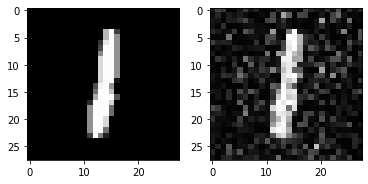

25  :  -0.8805015066882524 25
50  :  -0.8805015066882524 25
75  :  -0.8717087616360093 25
100  :  -0.8716557361630713 25
125  :  -0.8667845705622548 25
150  :  -0.866627991974628 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


175  :  -0.8664310468657568 25
200  :  -0.8641555242369225 25
225  :  -0.8596230407636839 25
250  :  -0.8575176692561444 25
275  :  -0.8557643984626977 25
300  :  -0.8557350282516741 25
325  :  -0.8536206231686312 25
350  :  -0.8536206231686312 25
375  :  -0.8518504878066163 25
400  :  -0.8513551655150905 25
425  :  -0.8501781048756556 25
450  :  -0.8428580530296836 25
475  :  -0.84176047591815 25
500  :  -0.7994522138186572 25
525  :  -0.5994371106006335 25
550  :  -0.1301887974750794 25
575  :  0.1751228260890812 25
600  :  0.24007963563078127 25
625  :  0.24258194958545137 25
650  :  0.31075565395276955 25
675  :  0.31075565395276955 25
700  :  0.34428770235560135 25
725  :  0.3390297974977105 25
750  :  0.3417870744885625 25
775  :  0.34173583395204865 25
800  :  0.3468649366400288 25
825  :  0.37247248093045343 25
850  :  0.3772595819612851 25
875  :  0.378576095954069 25
900  :  0.3869562761217481 25
925  :  0.3869562761217481 25
950  :  0.40361704914258134 25
975  :  0.405138298

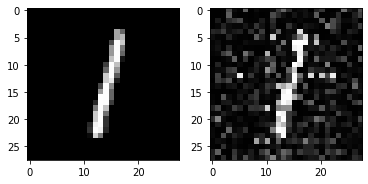

25  :  -0.8782817076471023 25
50  :  -0.8782817076471023 25
75  :  -0.8655495088693018 25
100  :  -0.860662213649089 25
125  :  -0.8517485087106961 25
150  :  -0.8429998808360073 25
175  :  -0.7789040424609346 25
200  :  -0.5450348102148078 25
225  :  0.0008765925022452548 25
250  :  0.15804037556236614 25
275  :  0.22352529609404131 25
300  :  0.29604474804936565 25
325  :  0.39012553432109437 25
350  :  0.3982004526218016 25
375  :  0.4165821224839626 25
400  :  0.4180071316347615 25
425  :  0.42115755883532163 25
450  :  0.42115755883532163 25
475  :  0.4233777175722115 25
500  :  0.439121235949228 25
525  :  0.4416542490971518 25
550  :  0.44453117575126466 25
575  :  0.44848995707008593 25
600  :  0.45246788797994714 25
625  :  0.45246788797994714 25
650  :  0.46354539641142245 25
675  :  0.4635442544385972 25
700  :  0.46413398310632736 25
725  :  0.4684581792505242 25
750  :  0.4717750928732513 25
775  :  0.4760910052875293 25
800  :  0.4765958416994623 25
825  :  0.476595841699

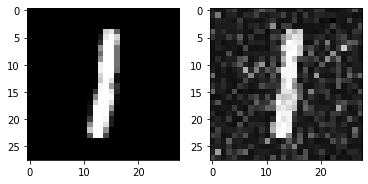

25  :  -0.6045625828306659 25
50  :  -0.3984070598147029 25
75  :  -0.15362990056944256 25
100  :  -0.08443866202366554 25
125  :  0.14932060291378646 25
150  :  0.23593950809333253 25
175  :  0.2657481164005937 25
200  :  0.2926361301059127 25
225  :  0.3398688834965174 25
250  :  0.346949439313523 25
275  :  0.36599609679278267 25
300  :  0.3658602681388167 25
325  :  0.38589149063835976 25
350  :  0.4208038449735694 25
375  :  0.4218899806858936 25
400  :  0.4369466829375207 25
425  :  0.45366671673392617 25
450  :  0.45379374512809795 25
475  :  0.46495706277129534 25
500  :  0.47342577393082763 25
525  :  0.47760663562624966 25
550  :  0.47760663562624966 25
575  :  0.47760663562624966 25
600  :  0.47760663562624966 25
625  :  0.4803536779762518 25
650  :  0.4803536779762518 25
675  :  0.4803536779762518 25
700  :  0.4831640717177868 25
725  :  0.4831640717177868 25
750  :  0.4848362653033434 25
775  :  0.48489439824029074 25
800  :  0.4867373112888143 25
825  :  0.487413438465618

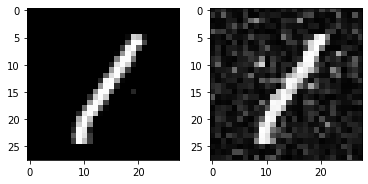

25  :  -0.8867583034361077 25
50  :  -0.8784293359368206 25
75  :  -0.8773308844661163 25
100  :  -0.8739470435902918 25
125  :  -0.8690291800278399 25
150  :  -0.8657601501124442 25
175  :  -0.8604948081432287 25
200  :  -0.8535559164613705 25
225  :  -0.8380338911751255 25
250  :  -0.8122200892939467 25
275  :  -0.5501557981859566 25
300  :  0.16754740412135088 25
325  :  0.3018755330868589 25
350  :  0.3256089301521166 25
375  :  0.3643058631276428 25
400  :  0.37034611018598834 25
425  :  0.3709207301782521 25
450  :  0.37196071868376296 25
475  :  0.3946611341677887 25
500  :  0.40775125971979415 25
525  :  0.42795704856419775 25
550  :  0.42795704856419775 25
575  :  0.45344839033248535 25
600  :  0.45344839033248535 25
625  :  0.4631388567785424 25
650  :  0.4638184981305567 25
675  :  0.4638184981305567 25
700  :  0.4638184981305567 25
725  :  0.4638184981305567 25
750  :  0.4664864847051216 25
775  :  0.4664864847051216 25
800  :  0.4703517415095315 25
825  :  0.47348741847853

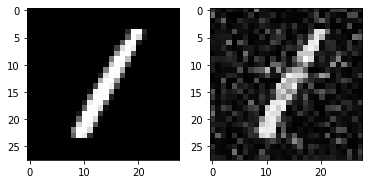

25  :  -0.8989984144271082 25
50  :  -0.896849328005129 25
75  :  -0.8943045785990575 25
100  :  -0.890211460726805 25
125  :  -0.882752227288573 25
150  :  -0.8811104606806047 25
175  :  -0.8799087710747179 25
200  :  -0.8785078560268937 25
225  :  -0.8737139873393521 25
250  :  -0.8736881996108277 25
275  :  -0.8705666621946593 25
300  :  -0.8691842085315208 25
325  :  -0.8687146109458636 25
350  :  -0.8669482901573906 25
375  :  -0.8669482901573906 25
400  :  -0.8661787363937418 25
425  :  -0.8650318993282997 25
450  :  -0.8649733419672496 25
475  :  -0.8644599452326782 25
500  :  -0.8636229053261241 25
525  :  -0.8636229053261241 25
550  :  -0.8636229053261241 25
575  :  -0.8636037723153858 25
600  :  -0.8632898265840457 25
625  :  -0.8632830531659226 25
650  :  -0.8630394299355868 25
675  :  -0.8628784487689205 25
700  :  -0.8626845966186398 25
725  :  -0.8624650081911236 25
750  :  -0.8624650081911236 25
775  :  -0.8624650081911236 25
800  :  -0.8623260987557777 25
Time:  78.3904

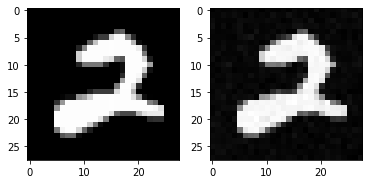

25  :  -0.8770776830376275 25
50  :  -0.8763617699712442 25
75  :  -0.875400267878868 25
100  :  -0.8733145481014424 25
125  :  -0.8730191635612348 25
150  :  -0.8695781477854101 25
175  :  -0.8693270860844939 25
200  :  -0.8686937825064123 25
225  :  -0.8673069491558034 25
250  :  -0.8623254780806743 25
275  :  -0.8623254780806743 25
300  :  -0.8623254780806743 25
325  :  -0.858172429167751 25
350  :  -0.8577704909904573 25
375  :  -0.8578308388407359 25
400  :  -0.8578308388407359 25
425  :  -0.8578308388407359 25
450  :  -0.8578308388407359 25
475  :  -0.8576004491451206 25
500  :  -0.8574600714547783 25
525  :  -0.8551986423396194 25
550  :  -0.8550519331989889 25
575  :  -0.854355571189482 25
600  :  -0.8543262166078922 25
625  :  -0.8543262166078922 25
650  :  -0.8538759067731873 25
675  :  -0.8526721464213661 25
700  :  -0.8515758221810202 25
725  :  -0.8515758221810202 25
750  :  -0.850480388795047 25
775  :  -0.8504593863729101 25
800  :  -0.8495485031120742 25
Time:  76.49804

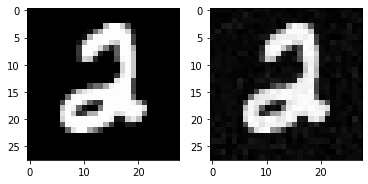

25  :  -0.527067222518655 25
50  :  -0.527067222518655 25
75  :  -0.41516174359681507 25
100  :  -0.44177956141247776 25
125  :  -0.48239297979637297 25
150  :  -0.41339619838233727 25
175  :  -0.4051458161132833 25
200  :  -0.30316384781425043 25
225  :  -0.3022404525450141 25
250  :  -0.15385468914169498 25
275  :  -0.07354083899509506 25
300  :  -0.07556873216119919 25
325  :  0.03196335662989647 25
350  :  0.01091786665401484 25
375  :  0.15136731178477797 25
400  :  0.15136731178477797 25
425  :  0.15136731178477797 25
450  :  0.2119020698625153 25
475  :  0.20305088229521956 25
500  :  0.22411694481494238 25
525  :  0.2284387681227107 25
550  :  0.21171484604803642 25
575  :  0.21171484604803642 25
600  :  0.2187440024987249 25
625  :  0.27283598312752017 25
650  :  0.27229047245520405 25
675  :  0.2925626011031959 25
700  :  0.3139389913166966 25
725  :  0.320017197773184 25
750  :  0.3326842632390228 25
775  :  0.34199854723971096 25
800  :  0.3495972143358198 25
825  :  0.3466

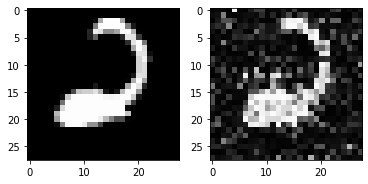

25  :  -0.8237473452427098 25
50  :  -0.8236420078056618 25
75  :  -0.8236420078056618 25
100  :  -0.8236420078056618 25
125  :  -0.8212562131860861 25
150  :  -0.8202204197786817 25
175  :  -0.8077463334644941 25
200  :  -0.7889541624501564 25
225  :  -0.7998244969944543 25
250  :  -0.7963701840995291 25
275  :  -0.7462480959919533 25
300  :  -0.7112059581998785 25
325  :  -0.5139036407346593 25
350  :  -0.3334405228705791 25
375  :  -0.04141876039009107 25
400  :  0.0365317859097114 25
425  :  0.10049444005454278 25
450  :  0.11542163280917284 25
475  :  0.1051256821536447 25
500  :  0.11026608935344628 25
525  :  0.12488787528080736 25
550  :  0.16936005666223586 25
575  :  0.1576684533380628 25
600  :  0.16995888742747445 25
625  :  0.1769068731077531 25
650  :  0.1823099956432206 25
675  :  0.2076749394190135 25
700  :  0.21275517764424223 25
725  :  0.2102356070552569 25
750  :  0.21568113476752016 25
775  :  0.21630084313074183 25
800  :  0.21973078258590162 25
825  :  0.2311680

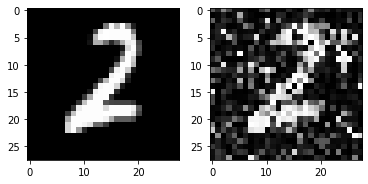

25  :  0.10632236645687937 25
50  :  0.12852210737620495 25
75  :  0.10891151018331935 25
100  :  0.060069848516076885 25
125  :  0.16125197303158612 25
150  :  0.11735117383009308 25
175  :  0.21238817658663806 25
200  :  0.20690319172610327 25
225  :  0.24763034277317442 25
250  :  0.27692055290359646 25
275  :  0.3077845759543235 25
300  :  0.3289367930258406 25
325  :  0.3254637822567753 25
350  :  0.3254637822567753 25
375  :  0.3254637822567753 25
400  :  0.3334626768740449 25
425  :  0.3440972515445058 25
450  :  0.3440972515445058 25
475  :  0.34764553544046106 25
500  :  0.3580869877267578 25
525  :  0.3580869877267578 25
550  :  0.36259185002968997 25
575  :  0.36647197404027526 25
600  :  0.36641873731252117 25
625  :  0.36641873731252117 25
650  :  0.37033024917961155 25
675  :  0.3749366203489229 25
700  :  0.37894645653893644 25
725  :  0.379653290542749 25
750  :  0.37946894381479845 25
775  :  0.3829630555342344 25
800  :  0.3829893275742003 25
825  :  0.385424096927735

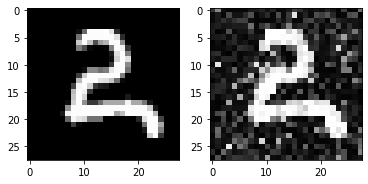

25  :  -0.1996406811729155 25
50  :  -0.1838730459482817 25
75  :  -0.030166334470533185 25
100  :  0.011432376198488026 25
125  :  0.19686897696082173 25
150  :  0.3170636434908236 25
175  :  0.4400436743635266 25
200  :  0.4383510076455809 25
225  :  0.45051240560875916 25
250  :  0.4887962606611177 25
275  :  0.4887962606611177 25
300  :  0.4920802854104646 25
325  :  0.4981869088866323 25
350  :  0.5223373038528483 25
375  :  0.5219161512303185 25
400  :  0.5219161512303185 25
425  :  0.5219161512303185 25
450  :  0.5219161512303185 25
475  :  0.5247543457693393 25
500  :  0.526411781729339 25
525  :  0.5294096409563078 25
550  :  0.5318585026480283 25
575  :  0.5322469715054612 25
600  :  0.5330117459662402 25
625  :  0.5337294235014862 25
650  :  0.5347826924724612 25
675  :  0.5357489185692458 25
700  :  0.5357499103658501 25
725  :  0.537289504072189 25
750  :  0.5377016548154185 25
775  :  0.5381066141557941 25
800  :  0.5381070798013632 25
825  :  0.5381553456875345 25
850  :

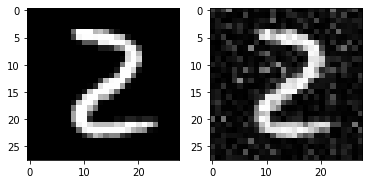

25  :  -0.849543887729612 25
50  :  -0.8456542456222466 25
75  :  -0.8414754246502708 25
100  :  -0.8414754246502708 25
125  :  -0.8300420440732784 25
150  :  -0.8300420440732784 25
175  :  -0.8270007096331343 25
200  :  -0.8209575924166279 25
225  :  -0.8179824007618801 25
250  :  -0.8180370426418119 25
275  :  -0.8123865282340791 25
300  :  -0.798345675899546 25
325  :  -0.7818459137154067 25
350  :  -0.7048070707114049 25
375  :  -0.5285892246959557 25
400  :  -0.13259279001731716 25
425  :  0.06700169249344023 25
450  :  0.15279763997314533 25
475  :  0.13508453228188044 25
500  :  0.14321144131083807 25
525  :  0.15768855827206707 25
550  :  0.16744210347152727 25
575  :  0.2021498614480703 25
600  :  0.21726964807422083 25
625  :  0.231279374178402 25
650  :  0.23947654811973962 25
675  :  0.24238731171140754 25
700  :  0.24238731171140754 25
725  :  0.2439129931860604 25
750  :  0.24839816289359418 25
775  :  0.2526906217757287 25
800  :  0.25878606884368827 25
825  :  0.2618109

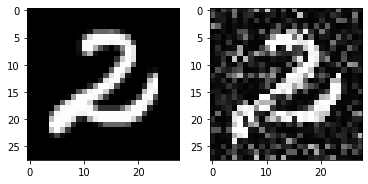

25  :  -0.5915596030400071 25
50  :  -0.49398023765814875 25
75  :  -0.5552366972272291 25
100  :  -0.5344590773956784 25
125  :  -0.5560186612009108 25
150  :  -0.549688012703972 25
175  :  -0.5226077582905942 25
200  :  -0.44976491650439987 25
225  :  -0.3102687651947601 25
250  :  -0.23158159806939246 25
275  :  -0.2952658079655882 25
300  :  -0.29943470855794874 25
325  :  -0.27811322661003485 25
350  :  -0.03026827803788018 25
375  :  -0.06370789736785376 25
400  :  -0.02273528775651179 25
425  :  0.10576766115218134 25
450  :  0.09055421863152185 25
475  :  0.06613277131168305 25
500  :  0.04118867063125192 25
525  :  0.10703991114500067 25
550  :  0.08500451897326639 25
575  :  0.15467133995719068 25
600  :  0.188415509998328 25
625  :  0.2166350067736741 25
650  :  0.2732631350302837 25
675  :  0.26571836376745334 25
700  :  0.26571836376745334 25
725  :  0.3256741689546427 25
750  :  0.324018000602191 25
775  :  0.324018000602191 25
800  :  0.32677093550610536 25
825  :  0.324

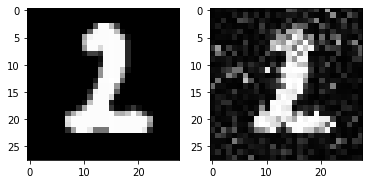

25  :  -0.8830928407775762 25
50  :  -0.8797424602486877 25
75  :  -0.8757111744730885 25
100  :  -0.8757111744730885 25
125  :  -0.8757111744730885 25
150  :  -0.8741674899071219 25
175  :  -0.8718760800262629 25
200  :  -0.8674339365743114 25
225  :  -0.8633024510393278 25
250  :  -0.8630858795768697 25
275  :  -0.8631067832038511 25
300  :  -0.8617399040182817 25
325  :  -0.8570294415295693 25
350  :  -0.856352894801698 25
375  :  -0.856200375133042 25
400  :  -0.8442153403013619 25
425  :  -0.8420687381620178 25
450  :  -0.7602887391059759 25
475  :  -0.6596862074169847 25
500  :  -0.13870851562514194 25
525  :  0.2674539571559953 25
550  :  0.27798987729480784 25
575  :  0.3112233040127782 25
600  :  0.3142119350611062 25
625  :  0.333998019476271 25
650  :  0.35075020060240913 25
675  :  0.3522294686663379 25
700  :  0.3522294686663379 25
725  :  0.3522294686663379 25
750  :  0.3695433029378806 25
775  :  0.37979890760278456 25
800  :  0.3871710003694053 25
825  :  0.401114543476

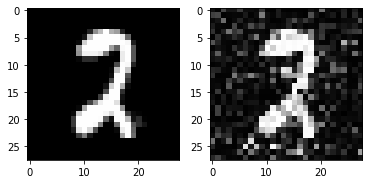

25  :  -0.7854682548418814 25
50  :  -0.7801762060047516 25
75  :  -0.7680105905516265 25
100  :  -0.6736925113295384 25
125  :  -0.6367549549939149 25
150  :  -0.5281063949312376 25
175  :  -0.22642615811145483 25
200  :  -0.16572911584142497 25
225  :  -0.006367469467666642 25
250  :  0.3261666509562532 25
275  :  0.3299668902081598 25
300  :  0.3574287639070152 25
325  :  0.3574287639070152 25
350  :  0.36875851305042223 25
375  :  0.3762311189849986 25
400  :  0.36807371224035657 25
425  :  0.38784407710433916 25
450  :  0.4052502171577585 25
475  :  0.4280797828936794 25
500  :  0.43431637598963196 25
525  :  0.4367294681511396 25
550  :  0.44268648620730183 25
575  :  0.4599569592952241 25
600  :  0.4599569592952241 25
625  :  0.4599569592952241 25
650  :  0.4599569592952241 25
675  :  0.4599569592952241 25
700  :  0.46519715469287753 25
725  :  0.46661111473361394 25
750  :  0.46661111473361394 25
775  :  0.46680769142153605 25
800  :  0.46707713502875886 25
825  :  0.4689102234

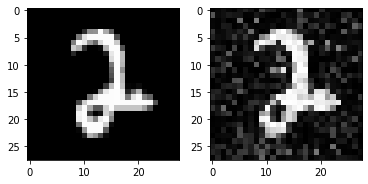

25  :  -0.8790029398788417 25
50  :  -0.8765276699122805 25
75  :  -0.8659727809093719 25
100  :  -0.8659727809093719 25
125  :  -0.8659727809093719 25
150  :  -0.8659727809093719 25
175  :  -0.8639476804966836 25
200  :  -0.8635548684427508 25
225  :  -0.8635634515589239 25
250  :  -0.8623740865068417 25
275  :  -0.8613275814548744 25
300  :  -0.860931648274504 25
325  :  -0.8575153321933713 25
350  :  -0.8575395234650436 25
375  :  -0.8573554257461004 25
400  :  -0.8557125448445945 25
425  :  -0.8531080330588493 25
450  :  -0.8531080330588493 25
475  :  -0.8529747538783122 25
500  :  -0.8524312107542482 25
525  :  -0.8522420448330993 25
550  :  -0.851238758484824 25
575  :  -0.8501965130871907 25
600  :  -0.8494508876368563 25
625  :  -0.8492701197894312 25
650  :  -0.8489141566400178 25
675  :  -0.8489141566400178 25
700  :  -0.8485523302335568 25
725  :  -0.8483559443248133 25
750  :  -0.8483242018704991 25
775  :  -0.847917813164637 25
800  :  -0.8470966336081033 25
825  :  -0.847

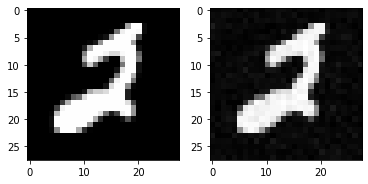

25  :  0.2151244949269765 25
50  :  0.22027692106235286 25
75  :  0.3197445473470858 25
100  :  0.4388003138982394 25
125  :  0.4216178939477494 25
150  :  0.43780918431744453 25
175  :  0.43618120268113875 25
200  :  0.45446091610856576 25
225  :  0.45818518250644735 25
250  :  0.47143252873583363 25
275  :  0.5001738460710159 25
300  :  0.49067764049540274 25
325  :  0.4917512614575159 25
350  :  0.49228009146808915 25
375  :  0.4942238774003136 25
400  :  0.49893350436313716 25
425  :  0.50946611049489 25
450  :  0.5194863455224966 25
475  :  0.5327769004258709 25
500  :  0.5327769004258709 25
525  :  0.5339983219925257 25
550  :  0.5339983219925257 25
575  :  0.5339983219925257 25
600  :  0.5339983219925257 25
625  :  0.5339983219925257 25
650  :  0.5426574360520773 25
675  :  0.5417772735645273 25
700  :  0.5468080165526236 25
725  :  0.5460947255823241 25
750  :  0.5491847804550988 25
775  :  0.5494893536675282 25
800  :  0.5514208903550197 25
825  :  0.5550031364284592 25
850  :

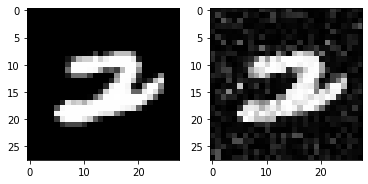

25  :  -0.058760275421586905 25
50  :  0.14914109065984682 25
75  :  -0.015108231663646832 25
100  :  0.0990727198227298 25
125  :  0.09419248553836645 25
150  :  0.1093613561107955 25
175  :  0.06538962166806617 25
200  :  0.11849311731089235 25
225  :  0.1516413563654675 25
250  :  0.15468901928446133 25
275  :  0.19821348957894946 25
300  :  0.17573347886019575 25
325  :  0.24783659619797593 25
350  :  0.24904874055370052 25
375  :  0.2531482166787259 25
400  :  0.24604251480443595 25
425  :  0.2530908496017268 25
450  :  0.27201375952326007 25
475  :  0.27794073855791207 25
500  :  0.2812050538009861 25
525  :  0.3031414352301779 25
550  :  0.30328703766509313 25
575  :  0.30328703766509313 25
600  :  0.309509097962681 25
625  :  0.3090427615346411 25
650  :  0.315027148969655 25
675  :  0.3150121124601178 25
700  :  0.3154301872846596 25
725  :  0.3230494881731969 25
750  :  0.3241755032917466 25
775  :  0.32416951700185836 25
800  :  0.32964606388852813 25
825  :  0.3280907739215

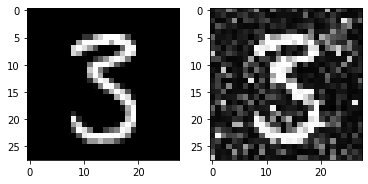

25  :  -0.8933574107340299 25
50  :  -0.8880306853427022 25
75  :  -0.8874135453051298 25
100  :  -0.8863481898396326 25
125  :  -0.8791709850362918 25
150  :  -0.8791709850362918 25
175  :  -0.8766131819272137 25
200  :  -0.8702262317764135 25
225  :  -0.8702262317764135 25
250  :  -0.8702262317764135 25
275  :  -0.8697347342527327 25
300  :  -0.8697347342527327 25
325  :  -0.8697347342527327 25
350  :  -0.869597899607338 25
375  :  -0.868851986166746 25
400  :  -0.8676263553547225 25
425  :  -0.866658085720608 25
450  :  -0.866658085720608 25
475  :  -0.866658085720608 25
500  :  -0.8653931275315645 25
525  :  -0.8653931275315645 25
550  :  -0.8652075128336905 25
575  :  -0.8644486016146767 25
600  :  -0.8641732271965099 25
625  :  -0.8636622455649041 25
650  :  -0.8636622455649041 25
675  :  -0.8636622455649041 25
700  :  -0.8632085544097695 25
725  :  -0.8632085544097695 25
750  :  -0.8632085544097695 25
775  :  -0.8632085544097695 25
800  :  -0.863132233561152 25
Time:  96.1688857

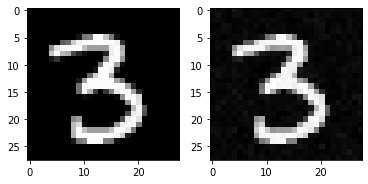

25  :  -0.8894161840549314 25
50  :  -0.887350401725553 25
75  :  -0.8814486141521267 25
100  :  -0.8746018775269762 25
125  :  -0.8746018775269762 25
150  :  -0.8744082916792559 25
175  :  -0.8734512915875681 25
200  :  -0.8687262911569269 25
225  :  -0.8686592417974603 25
250  :  -0.8679618812891562 25
275  :  -0.8679670072365449 25
300  :  -0.865861678190533 25
325  :  -0.8658548422437802 25
350  :  -0.8640430936701067 25
375  :  -0.8636879585516877 25
400  :  -0.8636180035543551 25
425  :  -0.8608331871162864 25
450  :  -0.8604928895435668 25
475  :  -0.8604928895435668 25
500  :  -0.8604928895435668 25
525  :  -0.860490633143049 25
550  :  -0.860078849655861 25
575  :  -0.860078849655861 25
600  :  -0.8595015334168233 25
625  :  -0.8595015334168233 25
650  :  -0.8591608697476184 25
675  :  -0.8591608697476184 25
700  :  -0.8591608697476184 25
725  :  -0.8586928316128999 25
750  :  -0.8584674907210974 25
775  :  -0.8582149834087257 25
800  :  -0.8582149834087257 25
Time:  100.22422

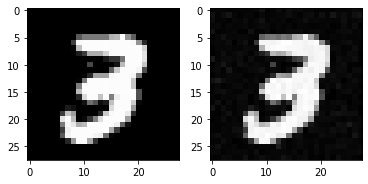

25  :  -0.8906665186173466 25
50  :  -0.8906553051025683 25
75  :  -0.8839666128967835 25
100  :  -0.883057549644423 25
125  :  -0.8820446701687142 25
150  :  -0.878837098306934 25
175  :  -0.8771688858592557 25
200  :  -0.8757369745974567 25
225  :  -0.8723941834236824 25
250  :  -0.8710979843575344 25
275  :  -0.8676340162961211 25
300  :  -0.8676329890838834 25
325  :  -0.8653669449789065 25
350  :  -0.8653669449789065 25
375  :  -0.8653669449789065 25
400  :  -0.8653669449789065 25
425  :  -0.8642385064466221 25
450  :  -0.8642385064466221 25
475  :  -0.8636613586183572 25
500  :  -0.8631113935298065 25
525  :  -0.8625748823006079 25
550  :  -0.8625748823006079 25
575  :  -0.8625748823006079 25
600  :  -0.8622908420955345 25
625  :  -0.8621852617413656 25
650  :  -0.861927516787816 25
675  :  -0.8618055871913352 25
700  :  -0.8615413651984107 25
725  :  -0.8615178795090023 25
750  :  -0.8614054360231338 25
775  :  -0.8613463135171346 25
800  :  -0.8611887669873444 25
Time:  91.9825

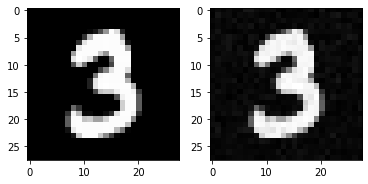

25  :  -0.3074224119947928 25
50  :  -0.20058228279771895 25
75  :  -0.5112425195314204 25
100  :  -0.3646153950513609 25
125  :  -0.8852725701693523 25
150  :  -0.8852725701693523 25
175  :  -0.8790349335546117 25
200  :  -0.3030665341585462 25
225  :  -0.5566451242262995 25
250  :  -0.8852725701693523 25
275  :  -0.8852725701693523 25
300  :  -0.8741405645858937 25
325  :  -0.8741405645858937 25
350  :  -0.8741405645858937 25
375  :  -0.8741405645858937 25
400  :  -0.8734403974224818 25
425  :  -0.8675882628825093 25
450  :  -0.8639455370288384 25
475  :  -0.8639455370288384 25
500  :  -0.8626939616556984 25
525  :  -0.8626939616556984 25
550  :  -0.8626939616556984 25
575  :  -0.8620871417535048 25
600  :  -0.8618465898981134 25
625  :  -0.8608817965049613 25
650  :  -0.8608817965049613 25
675  :  -0.8608817965049613 25
700  :  -0.8594583554027482 25
725  :  -0.8587494000351122 25
750  :  -0.8587494000351122 25
775  :  -0.8587494000351122 25
800  :  -0.8587326687403588 25
825  :  -0

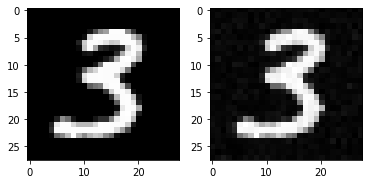

25  :  -0.8924796736663909 25
50  :  -0.8880660039012089 25
75  :  -0.8822073967270684 25
100  :  -0.88158874852051 25
125  :  -0.8789453658516587 25
150  :  -0.8785182392719576 25
175  :  -0.8741001030724771 25
200  :  -0.8738895476394787 25
225  :  -0.8707345322405798 25
250  :  -0.8707345322405798 25
275  :  -0.8700655251935436 25
300  :  -0.8678660864716154 25
325  :  -0.8678622256954578 25
350  :  -0.8678622256954578 25
375  :  -0.8646158217240568 25
400  :  -0.8646158217240568 25
425  :  -0.8646158217240568 25
450  :  -0.863626601442341 25
475  :  -0.8629551148183384 25
500  :  -0.8629551148183384 25
525  :  -0.8629551148183384 25
550  :  -0.8627597180900608 25
575  :  -0.8624688963050632 25
600  :  -0.8623847332472819 25
625  :  -0.8622728958951394 25
650  :  -0.8621588992322666 25
675  :  -0.8620867995442781 25
700  :  -0.8619542683431636 25
725  :  -0.8616484269246836 25
750  :  -0.8616484269246836 25
775  :  -0.8615918357521024 25
800  :  -0.861188910511796 25
Time:  101.7251

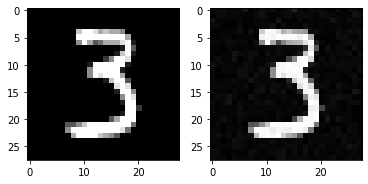

25  :  -0.8949761122207467 25
50  :  -0.8949761122207467 25
75  :  -0.8872784924884293 25
100  :  -0.8830450817983383 25
125  :  -0.8830450817983383 25
150  :  -0.879299258481764 25
175  :  -0.876004624759917 25
200  :  -0.876004624759917 25
225  :  -0.875776723094928 25
250  :  -0.87550058119619 25
275  :  -0.8714962575341041 25
300  :  -0.8709715355854117 25
325  :  -0.8700852606645622 25
350  :  -0.8700852606645622 25
375  :  -0.8693351087849056 25
400  :  -0.8692514219731114 25
425  :  -0.8676205091003489 25
450  :  -0.8669603969109138 25
475  :  -0.8669600873866352 25
500  :  -0.8664523965699097 25
525  :  -0.8664523965699097 25
550  :  -0.8664523965699097 25
575  :  -0.8664523965699097 25
600  :  -0.8661864774794299 25
625  :  -0.8653413230791772 25
650  :  -0.8651342333647412 25
675  :  -0.8646818261211869 25
700  :  -0.8644282627028536 25
725  :  -0.8643329866760914 25
750  :  -0.8639480256658161 25
775  :  -0.8639480256658161 25
800  :  -0.8638566665531509 25
Time:  103.069640

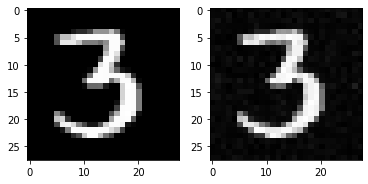

25  :  -0.8900711492459983 25
50  :  -0.8839637817423517 25
75  :  -0.8839637817423517 25
100  :  -0.8839637817423517 25
125  :  -0.8839637817423517 25
150  :  -0.8839637817423517 25
175  :  -0.8820009689309989 25
200  :  -0.8795659740056225 25
225  :  -0.8786749785018884 25
250  :  -0.8772091257830037 25
275  :  -0.873281417584562 25
300  :  -0.8697103819906193 25
325  :  -0.8697103819906193 25
350  :  -0.8691879751516861 25
375  :  -0.8685328994222002 25
400  :  -0.8685328994222002 25
425  :  -0.8683484159524283 25
450  :  -0.8672803922358622 25
475  :  -0.8671096779176254 25
500  :  -0.8666677359922289 25
525  :  -0.8666502004401846 25
550  :  -0.8654069436048264 25
575  :  -0.8654069436048264 25
600  :  -0.8651542013908745 25
625  :  -0.8651542013908745 25
650  :  -0.865073312264282 25
675  :  -0.865073312264282 25
700  :  -0.865073312264282 25
725  :  -0.8647646231034583 25
750  :  -0.8647646231034583 25
775  :  -0.8646682013458901 25
800  :  -0.8645982336066644 25
Time:  93.82941

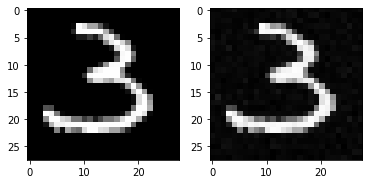

25  :  0.4647015813793913 25
50  :  0.4647015813793913 25
75  :  0.44249702636109245 25
100  :  0.46194330361464764 25
125  :  0.47331974784115943 25
150  :  0.46372577117589286 25
175  :  0.48426862853444513 25
200  :  0.5015763147914039 25
225  :  0.4898765624042889 25
250  :  0.4898765624042889 25
275  :  0.500492118556408 25
300  :  0.5036720589681126 25
325  :  0.513725054202189 25
350  :  0.5121921476891858 25
375  :  0.5196916997636163 25
400  :  0.5333949894313589 25
425  :  0.5342384787497152 25
450  :  0.5415721102349672 25
475  :  0.5415721102349672 25
500  :  0.5430234855607416 25
525  :  0.5430234855607416 25
550  :  0.5430234855607416 25
575  :  0.5451449666185859 25
600  :  0.5455087340133418 25
625  :  0.5469074228529474 25
650  :  0.5504269681387451 25
675  :  0.5532217455239735 25
700  :  0.5533820450851614 25
725  :  0.5538825796624974 25
750  :  0.5560184871377931 25
775  :  0.5563374472570475 25
800  :  0.5565390741953306 25
825  :  0.5569505033845414 25
850  :  0.

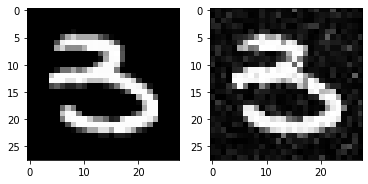

25  :  -0.29165324775448453 25
50  :  -0.29165324775448453 25
75  :  -0.2759241976025403 25
100  :  -0.2358809990951839 25
125  :  -0.11944114646778625 25
150  :  -0.10427322730750198 25
175  :  0.042437645210595204 25
200  :  0.22216296100426935 25
225  :  0.29264396311440205 25
250  :  0.33121325840249455 25
275  :  0.41236108400695887 25
300  :  0.43918703168500006 25
325  :  0.4433156250973403 25
350  :  0.4433156250973403 25
375  :  0.4433156250973403 25
400  :  0.4433156250973403 25
425  :  0.4433156250973403 25
450  :  0.4433156250973403 25
475  :  0.45883103745959813 25
500  :  0.45883103745959813 25
525  :  0.45883103745959813 25
550  :  0.4612446451432428 25
575  :  0.4612446451432428 25
600  :  0.47405832887030025 25
625  :  0.4752123988390377 25
650  :  0.476108016374136 25
675  :  0.4857809923916293 25
700  :  0.49287668317238864 25
725  :  0.4934884728357848 25
750  :  0.4982947106846803 25
775  :  0.4983099761976038 25
800  :  0.4983099761976038 25
825  :  0.504656879523

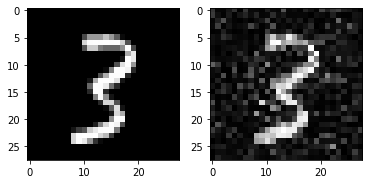

25  :  -0.8956589657261064 25
50  :  -0.8927823287336669 25
75  :  -0.8927757356153675 25
100  :  -0.8889094414481616 25
125  :  -0.8885842347932208 25
150  :  -0.8856433521329603 25
175  :  -0.8855209828752799 25
200  :  -0.8816353007334439 25
225  :  -0.8783470277912183 25
250  :  -0.8782705658735054 25
275  :  -0.8782705658735054 25
300  :  -0.8782705658735054 25
325  :  -0.8735154245442956 25
350  :  -0.8735154245442956 25
375  :  -0.8735154245442956 25
400  :  -0.8735154245442956 25
425  :  -0.8723662268709306 25
450  :  -0.8671488708521542 25
475  :  -0.8671488708521542 25
500  :  -0.8671488708521542 25
525  :  -0.8671488708521542 25
550  :  -0.8671488708521542 25
575  :  -0.8664775776172321 25
600  :  -0.8660888122601991 25
625  :  -0.8643747568237221 25
650  :  -0.8643747568237221 25
675  :  -0.8643747568237221 25
700  :  -0.8643747568237221 25
725  :  -0.8640388390772109 25
750  :  -0.8639311332481461 25
775  :  -0.8638441310078633 25
800  :  -0.863757002669613 25
Time:  101.3

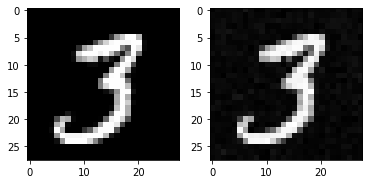

25  :  -0.38378363974521446 25
50  :  -0.1150483899993775 25
75  :  -0.8851911600458093 25
100  :  -0.878163359436058 25
125  :  -0.878163359436058 25
150  :  -0.8011767328426409 25
175  :  -0.878163359436058 25
200  :  -0.878163359436058 25
225  :  -0.875976462310871 25
250  :  -0.8758487921701595 25
275  :  -0.8715173141336883 25
300  :  -0.8657694219949202 25
325  :  -0.8646555685454247 25
350  :  -0.8646555685454247 25
375  :  -0.8637824690916106 25
400  :  -0.8631644246629291 25
425  :  -0.8615981675457776 25
450  :  -0.8605156032643743 25
475  :  -0.8602805027786514 25
500  :  -0.8597723334518589 25
525  :  -0.8594691207490672 25
550  :  -0.8588470578702352 25
575  :  -0.8588470578702352 25
600  :  -0.8588470578702352 25
625  :  -0.8588470578702352 25
650  :  -0.8584244473399699 25
675  :  -0.8584244473399699 25
700  :  -0.8584244473399699 25
725  :  -0.8584244473399699 25
750  :  -0.8584244473399699 25
775  :  -0.8584244473399699 25
800  :  -0.858363381846546 25
825  :  -0.85827

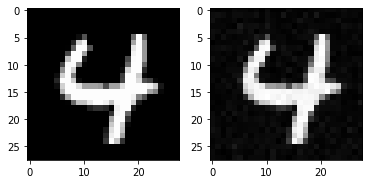

25  :  -0.482772401973252 25
50  :  -0.18178651765161158 25
75  :  -0.5622712200524133 25
100  :  -0.3705064620274538 25
125  :  -0.04332643089245369 25
150  :  -0.22060554287532794 25
175  :  -0.12197814586319944 25
200  :  -0.07913059078725743 25
225  :  -0.06989122049504226 25
250  :  -0.028135834197739185 25
275  :  0.018792635832432403 25
300  :  0.0815459321320346 25
325  :  0.07524651050394693 25
350  :  0.1405617023010564 25
375  :  0.17631957545819799 25
400  :  0.19122168170298393 25
425  :  0.19951330336947726 25
450  :  0.20820921798442743 25
475  :  0.23308809465694852 25
500  :  0.24429528038214038 25
525  :  0.2531270348324785 25
550  :  0.25914002383919604 25
575  :  0.2611332249081708 25
600  :  0.27646553022421866 25
625  :  0.2762718201837012 25
650  :  0.2793494336021916 25
675  :  0.28758405843459955 25
700  :  0.30911253048117054 25
725  :  0.30911253048117054 25
750  :  0.30911253048117054 25
775  :  0.31161623988068493 25
800  :  0.3150250449175046 25
825  :  0.

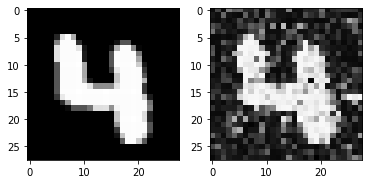

25  :  -0.6837498314304133 25
50  :  -0.2964909456690563 25
75  :  -0.4491900528502878 25
100  :  -0.7181776020986403 25
125  :  -0.7265665740956236 25
150  :  -0.5496035918551961 25
175  :  -0.343274578396829 25
200  :  -0.1866813444745266 25
225  :  -0.07831777496962805 25
250  :  0.01778083579826062 25
275  :  0.085677604550357 25
300  :  0.16076893581371554 25
325  :  0.17077103346250067 25
350  :  0.1794217366721722 25
375  :  0.18381424999935314 25
400  :  0.2361914211127068 25
425  :  0.23543297031539695 25
450  :  0.25574801969306 25
475  :  0.2568158772614305 25
500  :  0.2765996661600645 25
525  :  0.2766078391197979 25
550  :  0.2811654962969735 25
575  :  0.28743554273523453 25
600  :  0.2990949301674694 25
625  :  0.30529402961283963 25
650  :  0.30650534626391573 25
675  :  0.31494508214937383 25
700  :  0.31544648431455724 25
725  :  0.3184531235044813 25
750  :  0.3201557846269057 25
775  :  0.32023297826407854 25
800  :  0.3207371191731761 25
825  :  0.3215976599323810

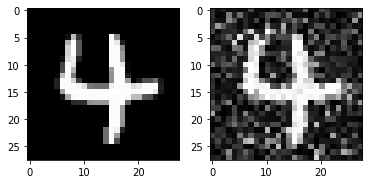

25  :  -0.8866210447108123 25
50  :  -0.8828946199453309 25
75  :  -0.8781934069115418 25
100  :  -0.8755129586798853 25
125  :  -0.8727553799579543 25
150  :  -0.8691169110669839 25
175  :  -0.8673694499279601 25
200  :  -0.8640923342161254 25
225  :  -0.8640923342161254 25
250  :  -0.8638234543315713 25
275  :  -0.8614385212156968 25
300  :  -0.8606799575264512 25
325  :  -0.8581921778878483 25
350  :  -0.8581921778878483 25
375  :  -0.8581921778878483 25
400  :  -0.8581921778878483 25
425  :  -0.8581921778878483 25
450  :  -0.8581921778878483 25
475  :  -0.858075246399485 25
500  :  -0.8574227830539835 25
525  :  -0.8573453924244154 25
550  :  -0.8573453924244154 25
575  :  -0.8568440149232252 25
600  :  -0.8565937638906712 25
625  :  -0.8561753028570905 25
650  :  -0.8559590512222447 25
675  :  -0.8552365989566363 25
700  :  -0.855171966999779 25
725  :  -0.8548510841226569 25
750  :  -0.8544812516318374 25
775  :  -0.8538780693120888 25
800  :  -0.8528490993661332 25
Time:  112.48

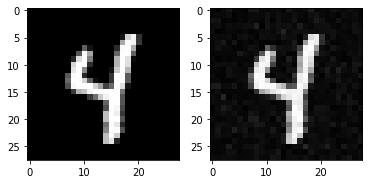

25  :  -0.4190268734745223 25
50  :  0.1533549361155383 25
75  :  0.03741810601551787 25
100  :  0.14860385665402587 25
125  :  0.2401003022402603 25
150  :  0.2649759355335232 25
175  :  0.2813773404735668 25
200  :  0.3287705241929332 25
225  :  0.3287705241929332 25
250  :  0.3304936718535515 25
275  :  0.3778026307305552 25
300  :  0.3822385338790423 25
325  :  0.38308893481929407 25
350  :  0.38596941366129744 25
375  :  0.4037069181199833 25
400  :  0.4037069181199833 25
425  :  0.41778819035874987 25
450  :  0.422471623141367 25
475  :  0.4242402789624975 25
500  :  0.4242402789624975 25
525  :  0.42864899256164096 25
550  :  0.4331080794428175 25
575  :  0.4349675937651724 25
600  :  0.43573590177510907 25
625  :  0.43739571721954923 25
650  :  0.43951505645311056 25
675  :  0.44865486389814224 25
700  :  0.4489457756986256 25
725  :  0.452351066390742 25
750  :  0.4623790995815738 25
775  :  0.46824771713738755 25
800  :  0.4696214284845514 25
825  :  0.4706082657425711 25
850

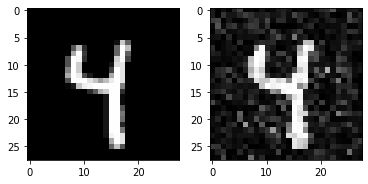

25  :  -0.6206124877478543 25
50  :  -0.6206124877478543 25
75  :  -0.3516080212331097 25
100  :  -0.037513854116766915 25
125  :  0.02417779829694003 25
150  :  0.18361050395632456 25
175  :  0.21391539070854637 25
200  :  0.2550225793043893 25
225  :  0.31137336490909 25
250  :  0.3306799830106995 25
275  :  0.33791272341642403 25
300  :  0.33791272341642403 25
325  :  0.3538649937475886 25
350  :  0.36064110797519433 25
375  :  0.42607640962186316 25
400  :  0.4495597963460577 25
425  :  0.4509484336477182 25
450  :  0.4640650385139318 25
475  :  0.4698828590561627 25
500  :  0.4699903602409756 25
525  :  0.5011640417365941 25
550  :  0.5004806878600853 25
575  :  0.5018561316430925 25
600  :  0.5015653437593057 25
625  :  0.501706586532144 25
650  :  0.5059923713869426 25
675  :  0.5118876162622586 25
700  :  0.5118876162622586 25
725  :  0.5118876162622586 25
750  :  0.5158767825646506 25
775  :  0.5174401343781444 25
800  :  0.5175868755489208 25
825  :  0.5194517015716378 25
850

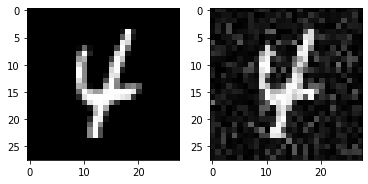

25  :  -0.8666327160710712 25
50  :  -0.8649091333375697 25
75  :  -0.8581565104212012 25
100  :  -0.8577634244570137 25
125  :  -0.849331349157817 25
150  :  -0.8473198341426644 25
175  :  -0.8472496997780488 25
200  :  -0.8472496997780488 25
225  :  -0.8472276301224878 25
250  :  -0.8472276301224878 25
275  :  -0.8459616851953075 25
300  :  -0.8426932007168355 25
325  :  -0.8421741013607862 25
350  :  -0.8370641977147855 25
375  :  -0.8370900088261527 25
400  :  -0.8313266999620238 25
425  :  -0.8276266884728144 25
450  :  -0.8191552689395 25
475  :  -0.7096753671821436 25
500  :  -0.3211032960034218 25
525  :  -0.04260687027928445 25
550  :  0.05857802864189071 25
575  :  0.1241035011927919 25
600  :  0.22520366031851324 25
625  :  0.2359801655418871 25
650  :  0.24441440111410395 25
675  :  0.24122699322008218 25
700  :  0.252736650705005 25
725  :  0.26114187165109437 25
750  :  0.266797096287651 25
775  :  0.2707195872742349 25
800  :  0.2923744013530298 25
825  :  0.292043523822

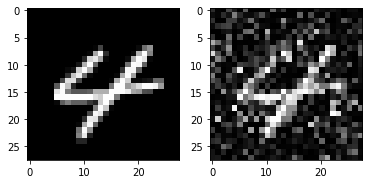

25  :  -0.893323335874502 25
50  :  -0.3933826764233681 25
75  :  -0.8503758078604817 25
100  :  -0.519963499156567 25
125  :  -0.8803887972387432 25
150  :  -0.8789091216865959 25
175  :  -0.8785911634123644 25
200  :  -0.8785911634123644 25
225  :  -0.8785911634123644 25
250  :  -0.8785911634123644 25
275  :  -0.8785911634123644 25
300  :  -0.8748024977768408 25
325  :  -0.8748024977768408 25
350  :  -0.8739020597684185 25
375  :  -0.8712672457185913 25
400  :  -0.871229305357849 25
425  :  -0.871229305357849 25
450  :  -0.8661108318730976 25
475  :  -0.8649769193276247 25
500  :  -0.864910007787495 25
525  :  -0.864910007787495 25
550  :  -0.8644418499493176 25
575  :  -0.8641253900929082 25
600  :  -0.8638611658605101 25
625  :  -0.8636813148901783 25
650  :  -0.8636794154194709 25
675  :  -0.8629243795356208 25
700  :  -0.8629047632717631 25
725  :  -0.8626276295074696 25
750  :  -0.86259337123225 25
775  :  -0.8624038279116059 25
800  :  -0.8622672860305781 25
825  :  -0.86215360

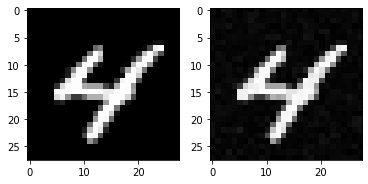

25  :  -0.8080195584349359 25
50  :  -0.8080195584349359 25
75  :  -0.7608915155756291 25
100  :  -0.4969004583353769 25
125  :  -0.021428094534900355 25
150  :  0.18218015624246686 25
175  :  0.32563948741805915 25
200  :  0.33757355697414126 25
225  :  0.33757355697414126 25
250  :  0.33757355697414126 25
275  :  0.33757355697414126 25
300  :  0.33757355697414126 25
325  :  0.39668365385915805 25
350  :  0.40192141963960826 25
375  :  0.4017357133089729 25
400  :  0.4296157239951739 25
425  :  0.42867310449612267 25
450  :  0.42867310449612267 25
475  :  0.42867310449612267 25
500  :  0.43251546816134806 25
525  :  0.43251546816134806 25
550  :  0.43472111532116353 25
575  :  0.43497807200269095 25
600  :  0.4349738229265149 25
625  :  0.44420145398943023 25
650  :  0.4442196719522361 25
675  :  0.44855422705383724 25
700  :  0.45064457221340753 25
725  :  0.4529115522565668 25
750  :  0.4590264954337356 25
775  :  0.4621499068973452 25
800  :  0.4639198418843213 25
825  :  0.4685849

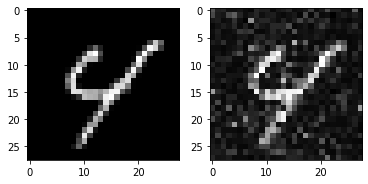

25  :  -0.8791070546171517 25
50  :  -0.8791070546171517 25
75  :  -0.8790885119484978 25
100  :  -0.8707169665161446 25
125  :  -0.8702788507992164 25
150  :  -0.8702788507992164 25
175  :  -0.868520954477664 25
200  :  -0.8627190030530638 25
225  :  -0.8627190030530638 25
250  :  -0.8613743222934479 25
275  :  -0.8613743222934479 25
300  :  -0.8596260040136823 25
325  :  -0.8595999230278432 25
350  :  -0.8595999230278432 25
375  :  -0.8583238990230553 25
400  :  -0.8581411312661629 25
425  :  -0.8575059564459866 25
450  :  -0.855287123529074 25
475  :  -0.8552881914780481 25
500  :  -0.8552881914780481 25
525  :  -0.8552881914780481 25
550  :  -0.8551712876158585 25
575  :  -0.8542831303826711 25
600  :  -0.8541041203383415 25
625  :  -0.8512244393558789 25
650  :  -0.8490587838008616 25
675  :  -0.8473757196149871 25
700  :  -0.8474453473148849 25
725  :  -0.8399078250187723 25
750  :  -0.8236832931423723 25
775  :  -0.7511098904438325 25
800  :  -0.5966383960454106 25
825  :  -0.11

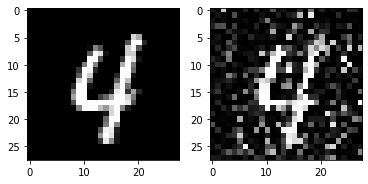

25  :  -0.3513895167034198 25
50  :  -0.06460055725356173 25
75  :  -0.1838939454626528 25
100  :  0.09719021355712198 25
125  :  0.11120954076549061 25
150  :  0.1504303122777083 25
175  :  0.13121411805026884 25
200  :  0.13507029390299874 25
225  :  0.18536935978276914 25
250  :  0.1887922782803244 25
275  :  0.20772355146394417 25
300  :  0.21462806143263868 25
325  :  0.21462806143263868 25
350  :  0.21462806143263868 25
375  :  0.22554593943371948 25
400  :  0.22232468860329557 25
425  :  0.22865621765877497 25
450  :  0.23090900075698284 25
475  :  0.2410965994360983 25
500  :  0.24491010658752377 25
525  :  0.24605234979501311 25
550  :  0.24853168892450217 25
575  :  0.25667677124158994 25
600  :  0.2566819947953274 25
625  :  0.2566819947953274 25
650  :  0.25922857691327283 25
675  :  0.2629841669513767 25
700  :  0.2629841669513767 25
725  :  0.26626526587973054 25
750  :  0.2685439286476041 25
775  :  0.27182970058238376 25
800  :  0.27182970058238376 25
825  :  0.27272185

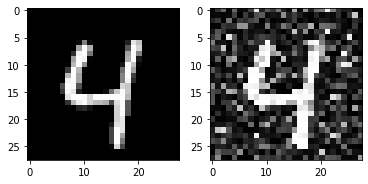

25  :  -0.0015965301295942091 25
50  :  0.22226020420282327 25
75  :  0.21073309535014761 25
100  :  0.17892741028296621 25
125  :  0.2500594514208809 25
150  :  0.14883141194209282 25
175  :  0.1557028133978937 25
200  :  0.19796091644355984 25
225  :  0.19796091644355984 25
250  :  0.2083956993421952 25
275  :  0.2410815982608509 25
300  :  0.24676416334150453 25
325  :  0.2682339394824174 25
350  :  0.2733820094973806 25
375  :  0.2733820094973806 25
400  :  0.2783642072708665 25
425  :  0.28883729968409244 25
450  :  0.2950342511898226 25
475  :  0.2950342511898226 25
500  :  0.2950342511898226 25
525  :  0.29651289668849834 25
550  :  0.29837961743397196 25
575  :  0.29882235727396755 25
600  :  0.3026173516976631 25
625  :  0.303999401003604 25
650  :  0.30765765894010233 25
675  :  0.3097280324496623 25
700  :  0.3196468388922799 25
725  :  0.31879574232479274 25
750  :  0.32400914468578884 25
775  :  0.32400914468578884 25
800  :  0.32511537386823963 25
825  :  0.33429398741833

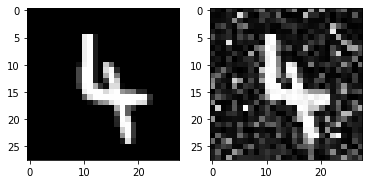

25  :  -0.4535897343467761 25
50  :  -0.3086942244068511 25
75  :  -0.1087099764245534 25
100  :  0.1561918680913389 25
125  :  0.206531952670989 25
150  :  0.35329486510086067 25
175  :  0.3276228830097049 25
200  :  0.3663147939847401 25
225  :  0.38846133853014386 25
250  :  0.38846133853014386 25
275  :  0.4068569605945297 25
300  :  0.42779007774864397 25
325  :  0.43861449898612 25
350  :  0.4424061930901567 25
375  :  0.4538977478063252 25
400  :  0.46287455466714633 25
425  :  0.46287455466714633 25
450  :  0.4720619417413158 25
475  :  0.4720619417413158 25
500  :  0.48107357849614085 25
525  :  0.48107217272940755 25
550  :  0.48304092490112 25
575  :  0.4834301491069349 25
600  :  0.4906607778803393 25
625  :  0.4906607778803393 25
650  :  0.49114535622458794 25
675  :  0.4911251803516905 25
700  :  0.49610463530792964 25
725  :  0.49610463530792964 25
750  :  0.4979119036097839 25
775  :  0.4999877648203609 25
800  :  0.5027585111283439 25
825  :  0.5085088043281705 25
850 

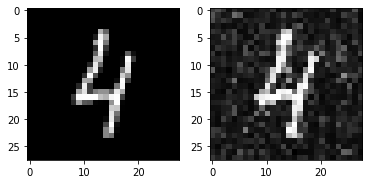

25  :  -0.7751926227662196 25
50  :  -0.7745139736381603 25
75  :  -0.753098263592572 25
100  :  -0.748415052910243 25
125  :  -0.748415052910243 25
150  :  -0.6929702098362002 25
175  :  -0.6640014643039605 25
200  :  -0.6590588267122303 25
225  :  -0.4479036848073506 25
250  :  -0.3089313616183701 25
275  :  0.015614572186811837 25
300  :  0.11612978064510904 25
325  :  0.2301918702999013 25
350  :  0.2216371497410734 25
375  :  0.2216371497410734 25
400  :  0.2681066128807927 25
425  :  0.299175618062636 25
450  :  0.31879389386671403 25
475  :  0.31879389386671403 25
500  :  0.31879389386671403 25
525  :  0.33451134565928525 25
550  :  0.36627531389495915 25
575  :  0.36771781912859614 25
600  :  0.36771781912859614 25
625  :  0.3893543061456814 25
650  :  0.39250484239009054 25
675  :  0.39413892548910145 25
700  :  0.4005289192018609 25
725  :  0.40269683045854665 25
750  :  0.40708016849030204 25
775  :  0.4102876666836751 25
800  :  0.4102876666836751 25
825  :  0.4110480516425

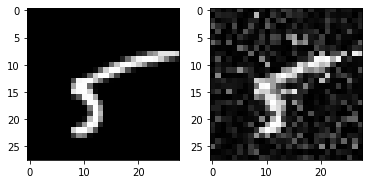

25  :  -0.7525598740370545 25
50  :  -0.6997514956109993 25
75  :  -0.6818327713527611 25
100  :  -0.6174023425645265 25
125  :  -0.4935277504307812 25
150  :  -0.028680151045621938 25
175  :  -0.13629440282693323 25
200  :  0.17815737653985303 25
225  :  0.14217579522276158 25
250  :  0.17937312987714304 25
275  :  0.2583621740123962 25
300  :  0.2667630132969831 25
325  :  0.331470600631581 25
350  :  0.3567715111536752 25
375  :  0.358389179487153 25
400  :  0.36554351897828746 25
425  :  0.37224905553765003 25
450  :  0.37427462842439 25
475  :  0.3988194343821417 25
500  :  0.39946571599462505 25
525  :  0.41089198333848015 25
550  :  0.43080867852501015 25
575  :  0.4394687486787135 25
600  :  0.4394687486787135 25
625  :  0.4470360243595389 25
650  :  0.4482177899399835 25
675  :  0.4578119699200527 25
700  :  0.45767298342598783 25
725  :  0.4577353377948425 25
750  :  0.46145928380276846 25
775  :  0.4673972408847439 25
800  :  0.46763625708449097 25
825  :  0.4681727758442163

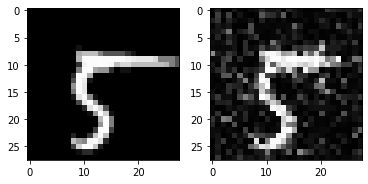

25  :  -0.8580142062717544 25
50  :  -0.8428779652124303 25
75  :  -0.8389755082591241 25
100  :  -0.8389755082591241 25
125  :  -0.8312356008728418 25
150  :  -0.8271569203321151 25
175  :  -0.8266292524186 25
200  :  -0.8249303988038502 25
225  :  -0.8229134214452022 25
250  :  -0.8186360487896036 25
275  :  -0.8185405781793524 25
300  :  -0.8162730594998001 25
325  :  -0.8148035611441683 25
350  :  -0.8090104547573949 25
375  :  -0.8059787398394028 25
400  :  -0.7960583018531984 25
425  :  -0.7891266258598695 25
450  :  -0.7510863493301098 25
475  :  -0.6988358482029178 25
500  :  -0.6736388103568314 25
525  :  -0.6740676501888688 25
550  :  -0.66512569186602 25
575  :  -0.6596663355907284 25
600  :  -0.6497426838825275 25
625  :  -0.6391104543701529 25
650  :  -0.6296873400378469 25
675  :  -0.6139961892171251 25
700  :  -0.5685512900249805 25
725  :  -0.574449212427654 25
750  :  -0.5457257751911987 25
775  :  -0.538541804558455 25
800  :  -0.537927431349426 25
825  :  -0.52983438

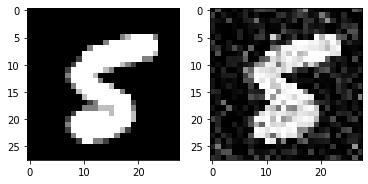

25  :  -0.8813678133353795 25
50  :  -0.8813678133353795 25
75  :  -0.8813678133353795 25
100  :  -0.8783034152285999 25
125  :  -0.8773460293210197 25
150  :  -0.8736414570320443 25
175  :  -0.8735760044642945 25
200  :  -0.8667912737851055 25
225  :  -0.8667912737851055 25
250  :  -0.8666569658229605 25
275  :  -0.8634998172588063 25
300  :  -0.8607993120403958 25
325  :  -0.8607993120403958 25
350  :  -0.8607993120403958 25
375  :  -0.8607993120403958 25
400  :  -0.8604010342094961 25
425  :  -0.8599254908623045 25
450  :  -0.859942112332224 25
475  :  -0.859942112332224 25
500  :  -0.859942112332224 25
525  :  -0.858264893878453 25
550  :  -0.8581634153972162 25
575  :  -0.8578674199805986 25
600  :  -0.8576526276373782 25
625  :  -0.8576526276373782 25
650  :  -0.8572277421702568 25
675  :  -0.8572277421702568 25
700  :  -0.8572277421702568 25
725  :  -0.857031037047539 25
750  :  -0.8568899045646818 25
775  :  -0.8565631758422101 25
800  :  -0.8559918119352704 25
Time:  116.99124

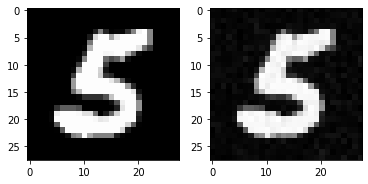

25  :  -0.8777890425265614 25
50  :  -0.8777890425265614 25
75  :  -0.8777890425265614 25
100  :  -0.874579256549842 25
125  :  -0.8715103033292413 25
150  :  -0.8635003808461603 25
175  :  -0.8624460997960152 25
200  :  -0.8595536254573407 25
225  :  -0.8578293358737773 25
250  :  -0.8578167081049184 25
275  :  -0.8570468300352817 25
300  :  -0.8556787466459254 25
325  :  -0.8549884038908502 25
350  :  -0.853450458888112 25
375  :  -0.853450458888112 25
400  :  -0.8513128709778773 25
425  :  -0.8513128709778773 25
450  :  -0.8511718506063807 25
475  :  -0.8511718506063807 25
500  :  -0.8502870503474516 25
525  :  -0.8502870503474516 25
550  :  -0.8492921702687924 25
575  :  -0.8487107744026336 25
600  :  -0.8472530605597509 25
625  :  -0.8472417065686466 25
650  :  -0.8472417065686466 25
675  :  -0.8468464692914627 25
700  :  -0.8467195993753485 25
725  :  -0.8463449834136255 25
750  :  -0.8460997616783663 25
775  :  -0.845718355176502 25
800  :  -0.8456498172167929 25
Time:  118.0749

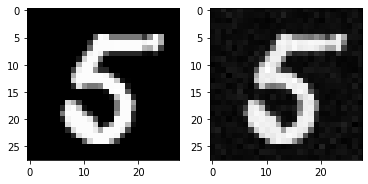

25  :  -0.6751585134301423 25
50  :  -0.6355437221738852 25
75  :  -0.5952155989452625 25
100  :  -0.5743255530538937 25
125  :  -0.523071341242909 25
150  :  -0.41555797305245956 25
175  :  -0.37079993980311177 25
200  :  -0.30612585030674133 25
225  :  -0.12667868445673114 25
250  :  -0.019378052234671594 25
275  :  0.03799056690169528 25
300  :  0.05226387012920214 25
325  :  0.07291253036781431 25
350  :  0.14035768291273043 25
375  :  0.12880986953412593 25
400  :  0.1463443353992917 25
425  :  0.17830612717688815 25
450  :  0.1967586466804594 25
475  :  0.212219608570328 25
500  :  0.2218556788352245 25
525  :  0.23941842667412283 25
550  :  0.27340492022615315 25
575  :  0.2732282385937408 25
600  :  0.2815218446879753 25
625  :  0.3017304182729381 25
650  :  0.34446447567849175 25
675  :  0.3453041421118912 25
700  :  0.36279514434063076 25
725  :  0.36279938265686446 25
750  :  0.36470114976584594 25
775  :  0.37865207789540256 25
800  :  0.3831056604533703 25
825  :  0.384959

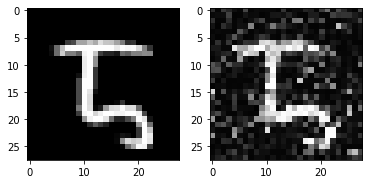

25  :  0.6311236658935315 25
50  :  0.6311236658935315 25
75  :  0.6394842415553651 25
100  :  0.6479580942404122 25
125  :  0.6500777085857671 25
150  :  0.6507157060440478 25
175  :  0.6597173875008495 25
200  :  0.6602767257359636 25
225  :  0.6659293148349743 25
250  :  0.6660854306861967 25
275  :  0.6668593327402279 25
300  :  0.6684771167030487 25
325  :  0.6697780074525792 25
350  :  0.6720576091880738 25
375  :  0.6729431228839837 25
400  :  0.6740792724090672 25
425  :  0.6742593114315103 25
450  :  0.676023375316783 25
475  :  0.6781213892725159 25
500  :  0.6781213892725159 25
525  :  0.6788654514143733 25
550  :  0.6809537977956573 25
575  :  0.6809537977956573 25
600  :  0.6821328649097858 25
625  :  0.682290671076337 25
650  :  0.6823633671630113 25
675  :  0.6823633671630113 25
700  :  0.6852221393914542 25
725  :  0.6852221393914542 25
750  :  0.686553401616396 25
775  :  0.686558246143055 25
800  :  0.686558246143055 25
Time:  110.16421866416931  seconds
Predicted cla

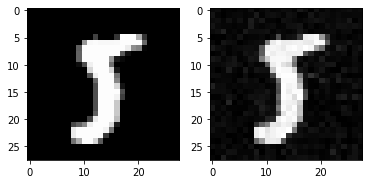

25  :  0.40097703293711795 25
50  :  0.4604553908953596 25
75  :  0.46104790910812554 25
100  :  0.46104790910812554 25
125  :  0.46104790910812554 25
150  :  0.4806998191985607 25
175  :  0.5016242006024929 25
200  :  0.5125817940975441 25
225  :  0.534683339747459 25
250  :  0.5432293599455029 25
275  :  0.5634267269956976 25
300  :  0.564395106994283 25
325  :  0.5674937733670803 25
350  :  0.5764225288261094 25
375  :  0.5802074304256779 25
400  :  0.5872087792640277 25
425  :  0.5943074958261938 25
450  :  0.6015772024827258 25
475  :  0.6120821298241406 25
500  :  0.611880854870021 25
525  :  0.611880854870021 25
550  :  0.611880854870021 25
575  :  0.6182981690296768 25
600  :  0.6188215725262507 25
625  :  0.6220193980178041 25
650  :  0.6220193980178041 25
675  :  0.6259261618000104 25
700  :  0.6262652283921497 25
725  :  0.6284450839409274 25
750  :  0.628447965062277 25
775  :  0.6302240957035208 25
800  :  0.6319596368994536 25
825  :  0.6333478800861434 25
850  :  0.63580

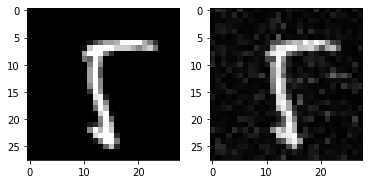

25  :  -0.44257483322535995 25
50  :  -0.44257483322535995 25
75  :  -0.4494031201360112 25
100  :  -0.33280792020568783 25
125  :  -0.24101742829244832 25
150  :  -0.14149382485667192 25
175  :  0.050581556173061426 25
200  :  0.21795718819225635 25
225  :  0.24893135906409053 25
250  :  0.28692002126756666 25
275  :  0.33228724535256304 25
300  :  0.34610748173744577 25
325  :  0.3483422941512776 25
350  :  0.363047750750654 25
375  :  0.3968611614370268 25
400  :  0.41083995699273423 25
425  :  0.4128192680633963 25
450  :  0.4346550998581899 25
475  :  0.4346550998581899 25
500  :  0.4346550998581899 25
525  :  0.43983099606347353 25
550  :  0.4419596408012498 25
575  :  0.443320772419859 25
600  :  0.4535417887894529 25
625  :  0.45385119609686697 25
650  :  0.4606988362761229 25
675  :  0.4691656562971718 25
700  :  0.4704052325700699 25
725  :  0.47211080242780035 25
750  :  0.47231380921578947 25
775  :  0.4723877456004794 25
800  :  0.47839353174812577 25
825  :  0.48678700173

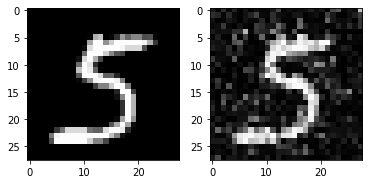

25  :  -0.351101998273486 25
50  :  -0.351101998273486 25
75  :  -0.3346379177539137 25
100  :  -0.26213570119110124 25
125  :  -0.18411619370888582 25
150  :  -0.09603454394052162 25
175  :  0.04162622542812383 25
200  :  0.09212129257401677 25
225  :  0.19583031349262228 25
250  :  0.3244663984884642 25
275  :  0.32935160746901065 25
300  :  0.331620879626433 25
325  :  0.32935160746901065 25
350  :  0.32935160746901065 25
375  :  0.32935160746901065 25
400  :  0.33230093833469043 25
425  :  0.3412329830720007 25
450  :  0.35217805235091415 25
475  :  0.3655666147100172 25
500  :  0.38148133038201465 25
525  :  0.3905292268363676 25
550  :  0.4010690149204271 25
575  :  0.41620291081722927 25
600  :  0.4213284487279106 25
625  :  0.42901911937505793 25
650  :  0.4499115685860335 25
675  :  0.4582458509322002 25
700  :  0.45715775833439054 25
725  :  0.45715775833439054 25
750  :  0.45955329251816407 25
775  :  0.46451176980025893 25
800  :  0.464941820288298 25
825  :  0.469044705970

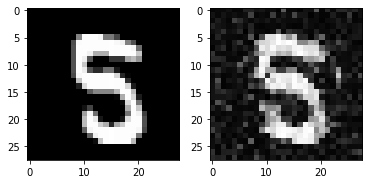

25  :  0.3065998646391009 25
50  :  0.33539707258766804 25
75  :  0.38616801734139805 25
100  :  0.41100519390925866 25
125  :  0.4569770159235239 25
150  :  0.49642513172287617 25
175  :  0.5238100974431247 25
200  :  0.5526254220385582 25
225  :  0.5526254220385582 25
250  :  0.5526254220385582 25
275  :  0.5526254220385582 25
300  :  0.5551373487007787 25
325  :  0.5585181096896008 25
350  :  0.563523287285479 25
375  :  0.5685944524572861 25
400  :  0.5685944524572861 25
425  :  0.5757383614309779 25
450  :  0.5784203677942711 25
475  :  0.585413208471273 25
500  :  0.5854107774414486 25
525  :  0.5863476222205624 25
550  :  0.5870007221343677 25
575  :  0.590342034559479 25
600  :  0.5981771568978063 25
625  :  0.5981640888783913 25
650  :  0.600082065412011 25
675  :  0.6033624973730356 25
700  :  0.6033741503572727 25
725  :  0.6052825171357752 25
750  :  0.606021498362077 25
775  :  0.6063205009839259 25
800  :  0.6066570577720077 25
825  :  0.6075731116360352 25
850  :  0.6086

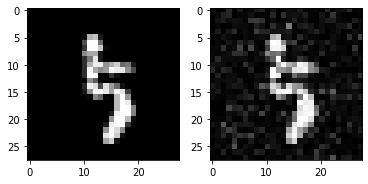

25  :  -0.7520735384940018 25
50  :  -0.7520735384940018 25
75  :  -0.7122890797114408 25
100  :  -0.7293676329097428 25
125  :  -0.7225033497118947 25
150  :  -0.7010701119996995 25
175  :  -0.6906760038012152 25
200  :  -0.6855803678094682 25
225  :  -0.5796801100427886 25
250  :  -0.4878661635834197 25
275  :  -0.30830667980406307 25
300  :  -0.27928783665080115 25
325  :  -0.12921108615178747 25
350  :  -0.04360298869972057 25
375  :  -0.020108289433282966 25
400  :  -0.008091778599460253 25
425  :  0.06755343389644158 25
450  :  0.09471479574160163 25
475  :  0.10096747244531673 25
500  :  0.1384161814465964 25
525  :  0.14281604960281746 25
550  :  0.15116349745608454 25
575  :  0.20275952237535882 25
600  :  0.23835974621980616 25
625  :  0.24695792293115565 25
650  :  0.2692927916847346 25
675  :  0.26903051069571304 25
700  :  0.27624342453583467 25
725  :  0.284191607080969 25
750  :  0.28920098578667536 25
775  :  0.29256899442142903 25
800  :  0.30411538758619144 25
825  : 

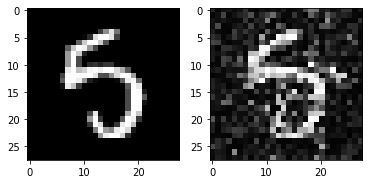

25  :  0.5643625928022199 25
50  :  0.5643625928022199 25
75  :  0.582608078464621 25
100  :  0.5853569332920624 25
125  :  0.5842366621262729 25
150  :  0.5866598320370054 25
175  :  0.5998136098364821 25
200  :  0.6050310739126403 25
225  :  0.6042761616933479 25
250  :  0.6052562584645331 25
275  :  0.6084614912329364 25
300  :  0.6122586184263678 25
325  :  0.6175669992986603 25
350  :  0.6169631812985341 25
375  :  0.6192884428923393 25
400  :  0.6216211888564153 25
425  :  0.6244094937392718 25
450  :  0.6256077540850732 25
475  :  0.6266848404927426 25
500  :  0.6280246626046734 25
525  :  0.628394809279447 25
550  :  0.6289083739253484 25
575  :  0.6303613642159448 25
600  :  0.6324411381827149 25
625  :  0.6330463765946394 25
650  :  0.6325407320950944 25
675  :  0.6370702962079807 25
700  :  0.6370546301389006 25
725  :  0.6370546301389006 25
750  :  0.6389216743473899 25
775  :  0.6390400705123851 25
800  :  0.6406670897616195 25
825  :  0.641681526442274 25
850  :  0.641905

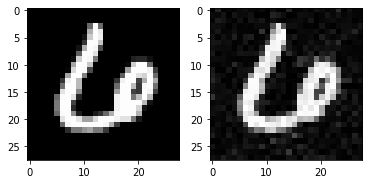

25  :  -0.271698592361311 25
50  :  -0.019293688956035893 25
75  :  0.02520186081641851 25
100  :  -0.015554260474477055 25
125  :  0.031123677866290334 25
150  :  0.0371984669381788 25
175  :  0.07651935216935102 25
200  :  0.11873532515985225 25
225  :  0.19999630106856792 25
250  :  0.22492368386336647 25
275  :  0.25945118186914023 25
300  :  0.260209650569838 25
325  :  0.260209650569838 25
350  :  0.26701236441152204 25
375  :  0.2737842186363291 25
400  :  0.3201019446848687 25
425  :  0.3263678304625064 25
450  :  0.3523457382412821 25
475  :  0.3523457382412821 25
500  :  0.356460961765052 25
525  :  0.3566600632254364 25
550  :  0.36865582953058196 25
575  :  0.36865582953058196 25
600  :  0.36865582953058196 25
625  :  0.36865582953058196 25
650  :  0.3745326485106509 25
675  :  0.3742588338873033 25
700  :  0.3742588338873033 25
725  :  0.3796329808246234 25
750  :  0.38317763667813026 25
775  :  0.3860704372260968 25
800  :  0.3861082619536998 25
825  :  0.390212655772966 

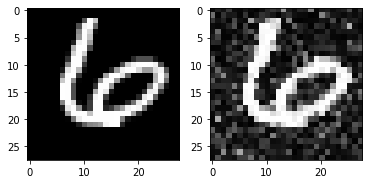

25  :  0.05173364146878312 25
50  :  0.09701137724228381 25
75  :  -0.23561009553137166 25
100  :  -0.884764411510091 25
125  :  -0.884764411510091 25
150  :  -0.884764411510091 25
175  :  -0.884764411510091 25
200  :  -0.884764411510091 25
225  :  -0.8843582200257345 25
250  :  -0.8839485333341274 25
275  :  -0.8781251022478263 25
300  :  -0.8777884412067763 25
325  :  -0.8769324344327104 25
350  :  -0.8695934404434519 25
375  :  -0.8694620002507488 25
400  :  -0.8693499947360472 25
425  :  -0.8693499947360472 25
450  :  -0.8693499947360472 25
475  :  -0.8679715238030569 25
500  :  -0.867782402107837 25
525  :  -0.8655886329112584 25
550  :  -0.8652466223022884 25
575  :  -0.8641896932236233 25
600  :  -0.8641896932236233 25
625  :  -0.8632789038511239 25
650  :  -0.8632588832412261 25
675  :  -0.8619149256865142 25
700  :  -0.8619149256865142 25
725  :  -0.8616402949690667 25
750  :  -0.8616402949690667 25
775  :  -0.8616402949690667 25
800  :  -0.8615290496921819 25
825  :  -0.86151

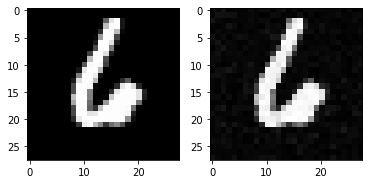

25  :  0.24120359741015834 25
50  :  0.2697865341278674 25
75  :  0.24978048012613824 25
100  :  0.20036681619229824 25
125  :  0.22076445416642826 25
150  :  0.2550505705911675 25
175  :  0.2769740167177715 25
200  :  0.26572074933257117 25
225  :  0.26874538145976906 25
250  :  0.2791281805795713 25
275  :  0.30725612371813854 25
300  :  0.3087392527308535 25
325  :  0.30973143178743506 25
350  :  0.32208724250640397 25
375  :  0.33126930560079665 25
400  :  0.3348031823065825 25
425  :  0.34112827473944496 25
450  :  0.34675759670859785 25
475  :  0.3539590393975587 25
500  :  0.3539590393975587 25
525  :  0.3539590393975587 25
550  :  0.35721725560329937 25
575  :  0.35745128546592303 25
600  :  0.3587707526825965 25
625  :  0.3588855848572917 25
650  :  0.361910164597322 25
675  :  0.36654066220278264 25
700  :  0.36722806855548884 25
725  :  0.36917480580569506 25
750  :  0.37063612991361033 25
775  :  0.37251326076997304 25
800  :  0.3735469014103626 25
825  :  0.374750273639623

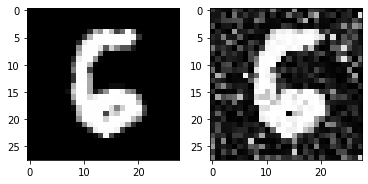

25  :  -0.5223308570294664 25
50  :  0.18753726349391803 25
75  :  0.14067154914395597 25
100  :  0.07098080273893581 25
125  :  0.11514604837548148 25
150  :  0.06172509499517642 25
175  :  0.14467761709081672 25
200  :  0.1970724377859665 25
225  :  0.21705657170107484 25
250  :  0.24883062305702786 25
275  :  0.24252857843550873 25
300  :  0.27769667696126116 25
325  :  0.291740678879224 25
350  :  0.32716582385864007 25
375  :  0.3525343263699249 25
400  :  0.3584870239828594 25
425  :  0.3584870239828594 25
450  :  0.35956824556009986 25
475  :  0.3704254440300134 25
500  :  0.3708746744556965 25
525  :  0.37629435682563017 25
550  :  0.3773326951866064 25
575  :  0.38156212519754434 25
600  :  0.3855849722201756 25
625  :  0.3855849722201756 25
650  :  0.3891595789279817 25
675  :  0.3913225545560963 25
700  :  0.3933027704882776 25
725  :  0.3964664688263971 25
750  :  0.3976704139137914 25
775  :  0.4002413787471011 25
800  :  0.4003861022968998 25
825  :  0.4012194300338579 25

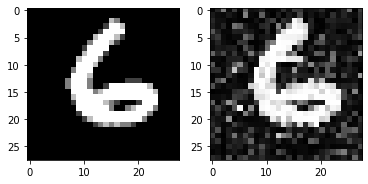

25  :  0.03459814174918274 25
50  :  0.04246879570910067 25
75  :  -0.1165670023776163 25
100  :  -0.0021398428877423825 25
125  :  0.06190432927839462 25
150  :  0.061852778229795735 25
175  :  0.035249776961464585 25
200  :  0.08179625833964432 25
225  :  0.12021545086449437 25
250  :  0.10997214169762926 25
275  :  0.12791259607637262 25
300  :  0.15144330678896012 25
325  :  0.17019993727417804 25
350  :  0.16887460867202597 25
375  :  0.16887460867202597 25
400  :  0.18609569491489963 25
425  :  0.18636579924875707 25
450  :  0.19484740713204374 25
475  :  0.19484740713204374 25
500  :  0.2069852595552254 25
525  :  0.20921505677618124 25
550  :  0.20911111160228169 25
575  :  0.2110463306170991 25
600  :  0.21573243187683966 25
625  :  0.21639141827782138 25
650  :  0.21934256921022355 25
675  :  0.21979528493427303 25
700  :  0.22763571773597013 25
725  :  0.22860773067453466 25
750  :  0.22853035646764752 25
775  :  0.23139646027494043 25
800  :  0.2341650754601744 25
825  :  0

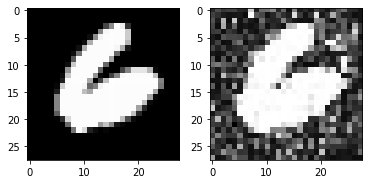

25  :  0.40226829044874474 25
50  :  0.40226829044874474 25
75  :  0.4041352867862654 25
100  :  0.42929647964841 25
125  :  0.4270300151320899 25
150  :  0.43395302213220616 25
175  :  0.4356371819757206 25
200  :  0.4528350796518146 25
225  :  0.4639494614936906 25
250  :  0.4639494614936906 25
275  :  0.47758212521941634 25
300  :  0.47794624542078196 25
325  :  0.4799071017313058 25
350  :  0.4894275853229376 25
375  :  0.49143604262706614 25
400  :  0.49143604262706614 25
425  :  0.4960393241047877 25
450  :  0.49630884747685144 25
475  :  0.5003001545805956 25
500  :  0.5041318259000366 25
525  :  0.5043045033684808 25
550  :  0.5045234188827444 25
575  :  0.5083694029567934 25
600  :  0.5103702378208215 25
625  :  0.5124460509735242 25
650  :  0.5145016991195764 25
675  :  0.5187646030125975 25
700  :  0.5205543337897796 25
725  :  0.5207423706496256 25
750  :  0.5248357638266445 25
775  :  0.5248357638266445 25
800  :  0.5248357638266445 25
825  :  0.5268234119571198 25
850  : 

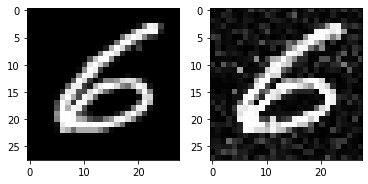

25  :  0.1937160210776635 25
50  :  0.26841790401675164 25
75  :  0.28980347581167926 25
100  :  0.26922920647817467 25
125  :  0.264836822062043 25
150  :  0.24400149036963092 25
175  :  0.2755758396666932 25
200  :  0.2844605027593479 25
225  :  0.33083252883641656 25
250  :  0.36128593498490996 25
275  :  0.3635732118791024 25
300  :  0.38137575906434673 25
325  :  0.38416764488919325 25
350  :  0.38416764488919325 25
375  :  0.38569624116001555 25
400  :  0.3870191599169592 25
425  :  0.3870191599169592 25
450  :  0.3947308202961204 25
475  :  0.3956206637703643 25
500  :  0.3996488269760214 25
525  :  0.4000861254617091 25
550  :  0.40267577371559954 25
575  :  0.41091526438772175 25
600  :  0.41117284034886337 25
625  :  0.41254834238070903 25
650  :  0.41387846971400155 25
675  :  0.41394783587977213 25
700  :  0.4165787996952946 25
725  :  0.41673155587935223 25
750  :  0.41802621880409513 25
775  :  0.4232458771944774 25
800  :  0.42365030603995757 25
825  :  0.426896760235043

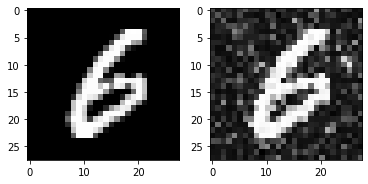

25  :  -0.7883223006650315 25
50  :  -0.06176569277791333 25
75  :  -0.8923717567963102 25
100  :  -0.889798415047108 25
125  :  -0.889798415047108 25
150  :  -0.889798415047108 25
175  :  -0.889798415047108 25
200  :  -0.889798415047108 25
225  :  -0.8873244610118336 25
250  :  -0.8860133688008235 25
275  :  -0.8855273958668487 25
300  :  -0.8853865508172418 25
325  :  -0.8848013629152102 25
350  :  -0.8787723662316861 25
375  :  -0.8775256532582018 25
400  :  -0.877511832693068 25
425  :  -0.877511832693068 25
450  :  -0.8762890480043145 25
475  :  -0.8738396852804231 25
500  :  -0.8712123747147933 25
525  :  -0.8712031875731776 25
550  :  -0.8696902296626952 25
575  :  -0.8696902296626952 25
600  :  -0.8684270048751184 25
625  :  -0.8679191794677164 25
650  :  -0.8659475933663237 25
675  :  -0.865944146506979 25
700  :  -0.8658160437254392 25
725  :  -0.8655214800085199 25
750  :  -0.8655214800085199 25
775  :  -0.8655214800085199 25
800  :  -0.8654428016450536 25
825  :  -0.8647454

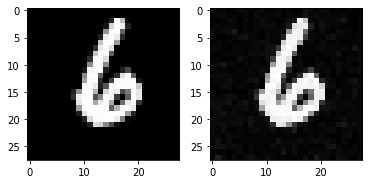

25  :  0.4344218539217162 25
50  :  0.4645654894432211 25
75  :  0.45639131605225636 25
100  :  0.4414777630602204 25
125  :  0.40723907894689426 25
150  :  0.4163749517083699 25
175  :  0.4393037592645892 25
200  :  0.4354359215621347 25
225  :  0.45719971637890133 25
250  :  0.46075542773634365 25
275  :  0.460529487647136 25
300  :  0.4637880796553018 25
325  :  0.46771325826672216 25
350  :  0.4665498019361962 25
375  :  0.4699847172542766 25
400  :  0.47247177480577585 25
425  :  0.47649962072093655 25
450  :  0.4838393123647144 25
475  :  0.4872972051697407 25
500  :  0.4879802424808176 25
525  :  0.4879802424808176 25
550  :  0.4879802424808176 25
575  :  0.49052027682561394 25
600  :  0.49268514804798 25
625  :  0.4924123644640179 25
650  :  0.500693712024038 25
675  :  0.5007052812976054 25
700  :  0.500660842164878 25
725  :  0.5035973287170692 25
750  :  0.5038576524432409 25
775  :  0.5058475668453323 25
800  :  0.5058465204869906 25
825  :  0.5058465204869906 25
850  :  0.

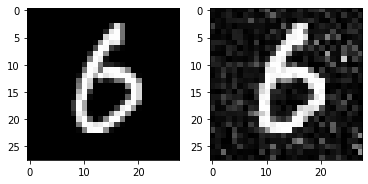

25  :  -0.7353304273531887 25
50  :  0.006963996387573612 25
75  :  -0.4148253890025396 25
100  :  -0.6084697532732888 25
125  :  -0.88356496748066 25
150  :  -0.8824596370783174 25
175  :  -0.8779813881530054 25
200  :  -0.8779813881530054 25
225  :  -0.8719794215649526 25
250  :  -0.8719794215649526 25
275  :  -0.8691514407619689 25
300  :  -0.8686839982805081 25
325  :  -0.863652527947851 25
350  :  -0.8635728182865645 25
375  :  -0.8635728182865645 25
400  :  -0.8628475283825353 25
425  :  -0.8624597654547309 25
450  :  -0.8624315691920974 25
475  :  -0.8624315691920974 25
500  :  -0.8618461344357269 25
525  :  -0.8586755737877864 25
550  :  -0.8586759876024797 25
575  :  -0.8586759876024797 25
600  :  -0.8582394927404424 25
625  :  -0.8580519256881597 25
650  :  -0.8578250908602426 25
675  :  -0.8575082018288819 25
700  :  -0.8574323144930918 25
725  :  -0.8571239926433962 25
750  :  -0.8571029048186702 25
775  :  -0.8569657653799263 25
800  :  -0.8567397407718663 25
825  :  -0.85

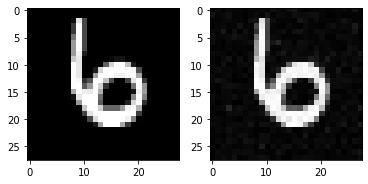

25  :  0.14237593512549435 25
50  :  0.22089528306525774 25
75  :  0.2039823009043249 25
100  :  0.23649342064920892 25
125  :  0.17942558389479446 25
150  :  0.25975989764993535 25
175  :  0.24316209223654806 25
200  :  0.25741737928381064 25
225  :  0.25563752888014574 25
250  :  0.25563752888014574 25
275  :  0.25563752888014574 25
300  :  0.2661164221775965 25
325  :  0.26716212180212895 25
350  :  0.2739212745208202 25
375  :  0.27797211587382936 25
400  :  0.2877352336276522 25
425  :  0.28516779684054167 25
450  :  0.2999710671515225 25
475  :  0.2999710671515225 25
500  :  0.3056735906617566 25
525  :  0.32333047495379535 25
550  :  0.32421001498405794 25
575  :  0.32421001498405794 25
600  :  0.32552433628573507 25
625  :  0.340138733612612 25
650  :  0.341853671365058 25
675  :  0.341853671365058 25
700  :  0.3431784453553351 25
725  :  0.34586174512923085 25
750  :  0.3477484743395697 25
775  :  0.34998512761783857 25
800  :  0.35240501871697566 25
825  :  0.3578489846230632

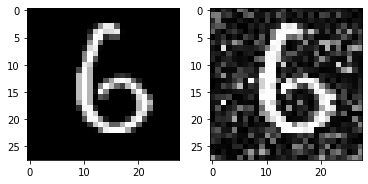

25  :  0.24641005373833064 25
50  :  0.30966661027010456 25
75  :  0.2784512607507493 25
100  :  0.264869486724314 25
125  :  0.37085174105022445 25
150  :  0.33794403148369456 25
175  :  0.3959514658490784 25
200  :  0.4143708405743165 25
225  :  0.4457129563873592 25
250  :  0.42549320128291845 25
275  :  0.42549320128291845 25
300  :  0.45870006703821814 25
325  :  0.4684884627841599 25
350  :  0.48445035407518955 25
375  :  0.48526835450484995 25
400  :  0.5051830754679443 25
425  :  0.5051830754679443 25
450  :  0.5152485220601851 25
475  :  0.5070359167718568 25
500  :  0.5197598680421703 25
525  :  0.5300138595828201 25
550  :  0.5320664177258594 25
575  :  0.5320388656193251 25
600  :  0.5466266165420284 25
625  :  0.5466143871075935 25
650  :  0.5466143871075935 25
675  :  0.5466143871075935 25
700  :  0.5651233351503566 25
725  :  0.5715285036691862 25
750  :  0.5709801215444082 25
775  :  0.5709801215444082 25
800  :  0.5709801215444082 25
825  :  0.5723818113268634 25
850  

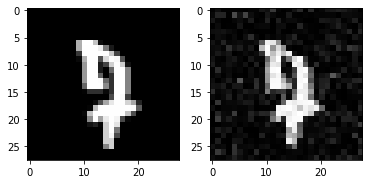

25  :  0.1546218345744803 25
50  :  0.1546218345744803 25
75  :  0.24033825427469666 25
100  :  0.28807353962265925 25
125  :  0.32600171621774315 25
150  :  0.34138203870853207 25
175  :  0.37358337053315976 25
200  :  0.39039131946706396 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


225  :  0.41460996466731537 25
250  :  0.41115606672264915 25
275  :  0.4450820342215437 25
300  :  0.4614152161285154 25
325  :  0.4614152161285154 25
350  :  0.4614152161285154 25
375  :  0.4755251077532796 25
400  :  0.470692383833079 25
425  :  0.4813579796896936 25
450  :  0.4910307935622763 25
475  :  0.48435140131709675 25
500  :  0.48435140131709675 25
525  :  0.4947517416320497 25
550  :  0.4943007764862871 25
575  :  0.49345046187232433 25
600  :  0.49345046187232433 25
625  :  0.500008784016096 25
650  :  0.49948527451338276 25
675  :  0.5036903378439652 25
700  :  0.508806971125732 25
725  :  0.5148290393180006 25
750  :  0.5145730188011699 25
775  :  0.5145730188011699 25
800  :  0.5149751281192049 25
825  :  0.5149751281192049 25
850  :  0.515108258667016 25
875  :  0.5151081172683921 25
900  :  0.5151081172683921 25
925  :  0.5151081172683921 25
950  :  0.515188868269177 25
975  :  0.5152928868789909 25
1000  :  0.5161692130210453 25
1025  :  0.5161932895585254 25
1050  

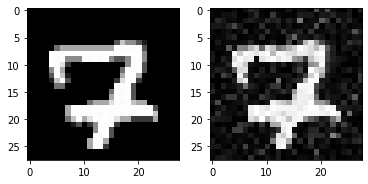

25  :  -0.8702653885711276 25
50  :  -0.8680880298674614 25
75  :  -0.860140195813355 25
100  :  -0.860140195813355 25
125  :  -0.860140195813355 25
150  :  -0.8534634440185478 25
175  :  -0.8534634440185478 25
200  :  -0.8448555402999203 25
225  :  -0.845017429375331 25
250  :  -0.8396334254347987 25
275  :  -0.48523525681441093 25
300  :  -0.7915083559999121 25
325  :  -0.47215892141344895 25
350  :  -0.11163876378095147 25
375  :  -0.040129327383686575 25
400  :  0.035279619974008025 25
425  :  0.1600044327153462 25
450  :  0.19186877777546263 25
475  :  0.19186877777546263 25
500  :  0.19186877777546263 25
525  :  0.19921828309502304 25
550  :  0.22809816742265904 25
575  :  0.23356700841927952 25
600  :  0.27251947931359055 25
625  :  0.29298788721112107 25
650  :  0.3246776230966737 25
675  :  0.334881651653119 25
700  :  0.33971007255075664 25
725  :  0.3469442340033634 25
750  :  0.36570746720302216 25
775  :  0.3660643508004421 25
800  :  0.36871021685007765 25
825  :  0.36871

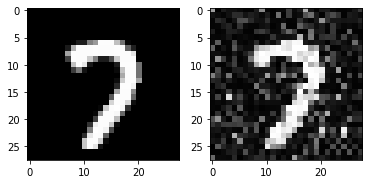

25  :  -0.8910184993580441 25
50  :  -0.8866069426449088 25
75  :  -0.595070262472739 25
100  :  -0.8823586490633022 25
125  :  -0.8763956417742332 25
150  :  -0.8763956417742332 25
175  :  -0.8763956417742332 25
200  :  -0.8681874077790656 25
225  :  -0.8681874077790656 25
250  :  -0.8673204531336957 25
275  :  -0.8666086067419903 25
300  :  -0.8666086067419903 25
325  :  -0.8630473048056497 25
350  :  -0.8627965758477765 25
375  :  -0.8627265313212145 25
400  :  -0.8627265313212145 25
425  :  -0.8602994703772127 25
450  :  -0.8602994703772127 25
475  :  -0.8602994703772127 25
500  :  -0.8601588829803014 25
525  :  -0.8601588829803014 25
550  :  -0.8598751364402294 25
575  :  -0.8596623081391462 25
600  :  -0.859610900355566 25
625  :  -0.8595455488018201 25
650  :  -0.8593643665167274 25
675  :  -0.8592875212146198 25
700  :  -0.8592018767058389 25
725  :  -0.8590407943486228 25
750  :  -0.8590407943486228 25
775  :  -0.8590407943486228 25
800  :  -0.8590191333641894 25
825  :  -0.85

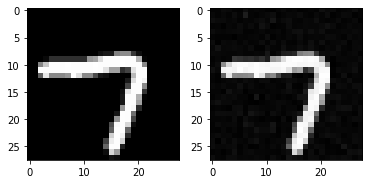

25  :  -0.8884150512604135 25
50  :  -0.8884150512604135 25
75  :  -0.8880968101333699 25
100  :  -0.8831535113174166 25
125  :  -0.8818040330651489 25
150  :  -0.8768139825930544 25
175  :  -0.8742815093798092 25
200  :  -0.8742815093798092 25
225  :  -0.8673450433643619 25
250  :  -0.8673450433643619 25
275  :  -0.8673450433643619 25
300  :  -0.8668356058075524 25
325  :  -0.8663131792882928 25
350  :  -0.8663373263674431 25
375  :  -0.865325422172238 25
400  :  -0.8644841866263225 25
425  :  -0.8639138604955169 25
450  :  -0.8636980307384291 25
475  :  -0.8631730776257034 25
500  :  -0.8631730776257034 25
525  :  -0.8631730776257034 25
550  :  -0.862363435340325 25
575  :  -0.8623629662512002 25
600  :  -0.8619795813879794 25
625  :  -0.8616247640525005 25
650  :  -0.8611308456426782 25
675  :  -0.8607488949311699 25
700  :  -0.8603451902251678 25
725  :  -0.8598119142652688 25
750  :  -0.8598118415207903 25
775  :  -0.8595377273763277 25
800  :  -0.8593402664329656 25
Time:  100.20

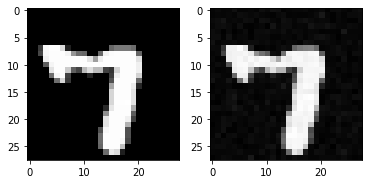

25  :  0.2988106433160776 25
50  :  0.2988106433160776 25
75  :  0.2988106433160776 25
100  :  0.3539813238240874 25
125  :  0.4029284868084889 25
150  :  0.37078758243776744 25
175  :  0.3796860414927543 25
200  :  0.43521650631323006 25
225  :  0.45458745340445345 25
250  :  0.45624199333957705 25
275  :  0.5045379720480699 25
300  :  0.4989463776759265 25
325  :  0.5002668395198921 25
350  :  0.5022001486333012 25
375  :  0.5022001486333012 25
400  :  0.556644449309277 25
425  :  0.5427339731294211 25
450  :  0.5427339731294211 25
475  :  0.5427339731294211 25
500  :  0.5427339731294211 25
525  :  0.5427339731294211 25
550  :  0.5427339731294211 25
575  :  0.550729691580289 25
600  :  0.5603195668840166 25
625  :  0.5577981863174877 25
650  :  0.5577981863174877 25
675  :  0.5577981863174877 25
700  :  0.5577981863174877 25
725  :  0.5588507312961974 25
750  :  0.5620649359368072 25
775  :  0.5676017365759163 25
800  :  0.5671204644421236 25
825  :  0.5717293234816584 25
850  :  0.5

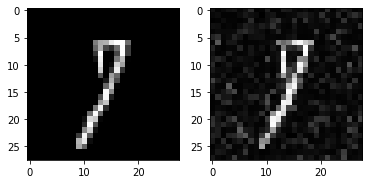

25  :  0.056395012218397544 25
50  :  0.1355154214113532 25
75  :  0.15864553992836972 25
100  :  0.2872350466089959 25
125  :  0.3845646793095452 25
150  :  0.431600324727374 25
175  :  0.4651381880103647 25
200  :  0.4908811627550412 25
225  :  0.49787369694036554 25
250  :  0.49787369694036554 25
275  :  0.5084495226655981 25
300  :  0.5180012692263276 25
325  :  0.5206877881733255 25
350  :  0.5260365637866509 25
375  :  0.5260406031085367 25
400  :  0.5264896823043026 25
425  :  0.5329050562915628 25
450  :  0.5327952724416278 25
475  :  0.5344853496265818 25
500  :  0.5419788804632717 25
525  :  0.5422396047126522 25
550  :  0.5422396047126522 25
575  :  0.5488539450005552 25
600  :  0.5488539450005552 25
625  :  0.5495531722392747 25
650  :  0.5495531733977465 25
675  :  0.5519668451274262 25
700  :  0.5519889351665873 25
725  :  0.5519889351665873 25
750  :  0.5538036133722939 25
775  :  0.5538020038167764 25
800  :  0.5538020038167764 25
825  :  0.554399634622535 25
850  :  0.

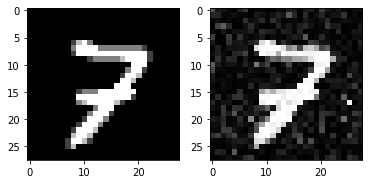

25  :  -0.7938615168257763 25
50  :  -0.6912536105843787 25
75  :  -0.5207854605496506 25
100  :  -0.614141710127305 25
125  :  -0.6980303109813859 25
150  :  -0.09771684739193481 25
175  :  -0.6620403101451908 25
200  :  -0.3693897714697817 25
225  :  -0.19394894310400088 25
250  :  0.028902110031500006 25
275  :  0.12583571949172823 25
300  :  0.1251549077093579 25
325  :  0.1691478196157966 25
350  :  0.15169490885040227 25
375  :  0.17876366829726176 25
400  :  0.18230400759908938 25
425  :  0.1832097288125185 25
450  :  0.18536216291139562 25
475  :  0.2169389610505803 25
500  :  0.25398601928431064 25
525  :  0.25540818319087805 25
550  :  0.25540818319087805 25
575  :  0.25540818319087805 25
600  :  0.25540818319087805 25
625  :  0.25540818319087805 25
650  :  0.25755443766231023 25
675  :  0.2600252063225008 25
700  :  0.26267754239014973 25
725  :  0.26567321071404293 25
750  :  0.2673102318486019 25
775  :  0.27374546552273404 25
800  :  0.27374546552273404 25
825  :  0.27861

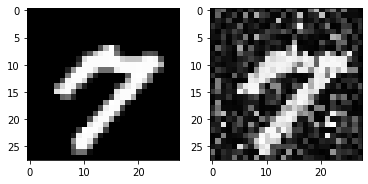

25  :  -0.8971708483583067 25
50  :  -0.8933626618103137 25
75  :  -0.8875190941864369 25
100  :  -0.8821698813163419 25
125  :  -0.8807246965597195 25
150  :  -0.8795831218474514 25
175  :  -0.8795768955787427 25
200  :  -0.8790011897194835 25
225  :  -0.875324012586333 25
250  :  -0.873472145194689 25
275  :  -0.8734250330514992 25
300  :  -0.8713708302283812 25
325  :  -0.8713708302283812 25
350  :  -0.8694242152803404 25
375  :  -0.8670666617179951 25
400  :  -0.8670666617179951 25
425  :  -0.8670666617179951 25
450  :  -0.8670666617179951 25
475  :  -0.8666550239553323 25
500  :  -0.8660322278443302 25
525  :  -0.8660322278443302 25
550  :  -0.8655328785805384 25
575  :  -0.8654686031419498 25
600  :  -0.8650321538447535 25
625  :  -0.8650321538447535 25
650  :  -0.865016404619771 25
675  :  -0.8649099637938348 25
700  :  -0.8649099637938348 25
725  :  -0.8647265811514837 25
750  :  -0.8645236632416822 25
775  :  -0.8644733143037795 25
800  :  -0.8641277494980366 25
Time:  76.6900

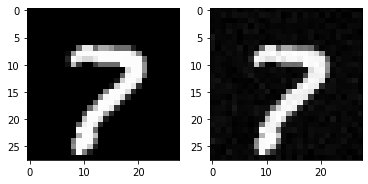

25  :  -0.8871274207668031 25
50  :  -0.8824384305482821 25
75  :  -0.8797260089280975 25
100  :  -0.8796658028516142 25
125  :  -0.8796658028516142 25
150  :  -0.8750989416204569 25
175  :  -0.8722915435008062 25
200  :  -0.8722915435008062 25
225  :  -0.8700278793402582 25
250  :  -0.869404594539195 25
275  :  -0.8690181582063871 25
300  :  -0.8650703264921926 25
325  :  -0.8650703264921926 25
350  :  -0.8644870887460219 25
375  :  -0.8632098302596675 25
400  :  -0.8624155377464086 25
425  :  -0.8624392528559947 25
450  :  -0.8624392528559947 25
475  :  -0.8615456904632905 25
500  :  -0.8615456904632905 25
525  :  -0.8615398144055639 25
550  :  -0.8615398144055639 25
575  :  -0.8611192192296209 25
600  :  -0.8601191981665021 25
625  :  -0.8599744538958797 25
650  :  -0.8592304686189989 25
675  :  -0.8592304686189989 25
700  :  -0.8591603844846465 25
725  :  -0.8591603844846465 25
750  :  -0.859109417373497 25
775  :  -0.8587379537706681 25
800  :  -0.8582391831925413 25
Time:  74.747

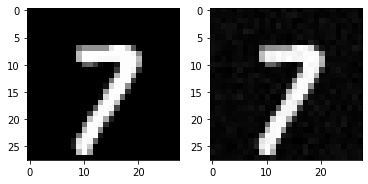

25  :  -0.6912076493516717 25
50  :  -0.40037558886943136 25
75  :  -0.3015950136571821 25
100  :  0.044615954337357044 25
125  :  0.22741279610765552 25
150  :  0.3267383192017464 25
175  :  0.33628315063623004 25
200  :  0.3472972626445751 25
225  :  0.3561641162763783 25
250  :  0.35917169005455063 25
275  :  0.3765426539607307 25
300  :  0.37979055006179746 25
325  :  0.3831376742750858 25
350  :  0.40026458455588343 25
375  :  0.40401121821900626 25
400  :  0.40414500875953097 25
425  :  0.4056833091075223 25
450  :  0.40604412901029274 25
475  :  0.411813153261271 25
500  :  0.4132273216692149 25
525  :  0.4160269462926194 25
550  :  0.42106238212286545 25
575  :  0.4235928040117826 25
600  :  0.4249769505381846 25
625  :  0.425574407249886 25
650  :  0.4280997095629535 25
675  :  0.42815488585215766 25
700  :  0.42815488585215766 25
725  :  0.4290356970350072 25
750  :  0.4290356970350072 25
775  :  0.42926968117131076 25
800  :  0.42926968117131076 25
825  :  0.4296260898403649

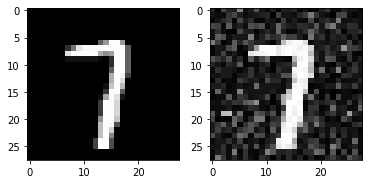

25  :  -0.8926636092855758 25
50  :  -0.8900747362033699 25
75  :  -0.8892535455388562 25
100  :  -0.8884385178912914 25
125  :  -0.8882127337906215 25
150  :  -0.8808596661544194 25
175  :  -0.879934456642305 25
200  :  -0.879934456642305 25
225  :  -0.876580698401983 25
250  :  -0.8762872350324528 25
275  :  -0.8740140739857757 25
300  :  -0.8699677288891922 25
325  :  -0.8699677288891922 25
350  :  -0.8696000042165355 25
375  :  -0.8689750735727549 25
400  :  -0.8676565912310046 25
425  :  -0.8670086709966563 25
450  :  -0.8668675414809833 25
475  :  -0.8655145684012101 25
500  :  -0.8648569959059857 25
525  :  -0.864323750582622 25
550  :  -0.8637988904537773 25
575  :  -0.8637988904537773 25
600  :  -0.8637611213350644 25
625  :  -0.8637611213350644 25
650  :  -0.8633959870760924 25
675  :  -0.8633959870760924 25
700  :  -0.86327720400501 25
725  :  -0.86327720400501 25
750  :  -0.8629759519268423 25
775  :  -0.8629481220452031 25
800  :  -0.8627764898363104 25
Time:  75.035194396

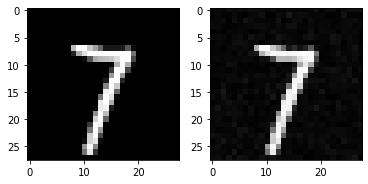

25  :  -0.658047895458203 25
50  :  -0.5334961297485494 25
75  :  -0.5576728172327546 25
100  :  -0.1680742070943974 25
125  :  0.03749671929652554 25
150  :  0.34946872835314086 25
175  :  0.40499221624493353 25
200  :  0.4058595549691034 25
225  :  0.4242134374887007 25
250  :  0.42604467135470114 25
275  :  0.43534935971336464 25
300  :  0.4447900907459695 25
325  :  0.45318280480566087 25
350  :  0.4557403076646146 25
375  :  0.47712793625188404 25
400  :  0.47717429668019934 25
425  :  0.47996742448020446 25
450  :  0.4832750039094091 25
475  :  0.4831925870837498 25
500  :  0.48448373769030395 25
525  :  0.49148277044219946 25
550  :  0.4917758406879176 25
575  :  0.4920253624848181 25
600  :  0.49915398879839507 25
625  :  0.49915398879839507 25
650  :  0.49915398879839507 25
675  :  0.49975182538838864 25
700  :  0.5005567802156718 25
725  :  0.501249287263695 25
750  :  0.5021074785984507 25
775  :  0.5034574151807665 25
800  :  0.5051828606900673 25
825  :  0.5064350995800988

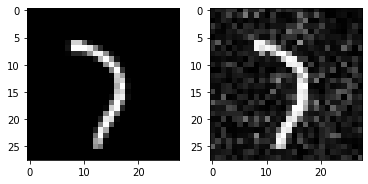

25  :  -0.18395487294438312 25
50  :  0.17607518953680035 25
75  :  -0.5057750067898953 25
100  :  0.11067964210020192 25
125  :  -0.8200402309457926 25
150  :  -0.8901305207078911 25
175  :  -0.8769604128361924 25
200  :  -0.8769604128361924 25
225  :  -0.8769604128361924 25
250  :  -0.8694157313273368 25
275  :  -0.8694171389950539 25
300  :  -0.8678909246895347 25
325  :  -0.8678909246895347 25
350  :  -0.8678909246895347 25
375  :  -0.8678863132253045 25
400  :  -0.8678909246895347 25
425  :  -0.8668235587336206 25
450  :  -0.8653381592825933 25
475  :  -0.8637969153021411 25
500  :  -0.8637950395515398 25
525  :  -0.8637950395515398 25
550  :  -0.8631501925008345 25
575  :  -0.8631546715084075 25
600  :  -0.8631546715084075 25
625  :  -0.8631546715084075 25
650  :  -0.8626406592516604 25
675  :  -0.862588544069302 25
700  :  -0.8617902494263914 25
725  :  -0.8617902494263914 25
750  :  -0.8617338448953101 25
775  :  -0.8617338448953101 25
800  :  -0.8617338448953101 25
825  :  -0.

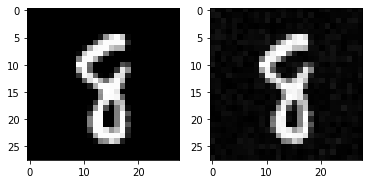

25  :  -0.8557172848803272 25
50  :  0.05800623286240936 25
75  :  -0.0020512875450483525 25
100  :  0.15084413204276903 25
125  :  0.07726166357490372 25
150  :  -0.8738199400602578 25
175  :  -0.8740548852350849 25
200  :  -0.7005774868737393 25
225  :  -0.5504812941707896 25
250  :  -0.8740548852350849 25
275  :  -0.8156976028688211 25
300  :  -0.8703457283690901 25
325  :  -0.8703457283690901 25
350  :  -0.8703457283690901 25
375  :  -0.869646916741504 25
400  :  -0.869646916741504 25
425  :  -0.869646916741504 25
450  :  -0.8695291194280312 25
475  :  -0.8695295419801543 25
500  :  -0.8695295419801543 25
525  :  -0.8695295419801543 25
550  :  -0.8658513449073124 25
575  :  -0.8656563191393383 25
600  :  -0.8621232075242868 25
625  :  -0.8621312400623351 25
650  :  -0.8607055863828573 25
675  :  -0.8607055863828573 25
700  :  -0.8607055863828573 25
725  :  -0.8603660231336516 25
750  :  -0.860367894881813 25
775  :  -0.859634826156578 25
800  :  -0.859634826156578 25
825  :  -0.858

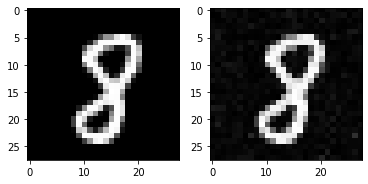

25  :  0.08840942414257369 25
50  :  0.08840942414257369 25
75  :  0.0472436313818142 25
100  :  0.08532231460836903 25
125  :  0.0598001597429525 25
150  :  -0.01802037414778357 25
175  :  -0.043615774814138475 25
200  :  -0.009808298825300987 25
225  :  -0.9046631880698762 25
250  :  -0.9046631880698762 25
275  :  -0.02548975818551491 25
300  :  0.050107132906614615 25
325  :  -0.9024954629042556 25
350  :  -0.8929736854487316 25
375  :  -0.8924271465606208 25
400  :  -0.8924271465606208 25
425  :  -0.8924271465606208 25
450  :  -0.8924271465606208 25
475  :  -0.8924271465606208 25
500  :  -0.8924271465606208 25
525  :  -0.8924271465606208 25
550  :  -0.892266351688792 25
575  :  -0.8893824297442573 25
600  :  -0.8865486008692152 25
625  :  -0.8865489448845316 25
650  :  -0.8865489448845316 25
675  :  -0.8845273305636155 25
700  :  -0.8843314715624444 25
725  :  -0.883720552621508 25
750  :  -0.8829006907710373 25
775  :  -0.881793162021235 25
800  :  -0.8815372253588176 25
825  :  -

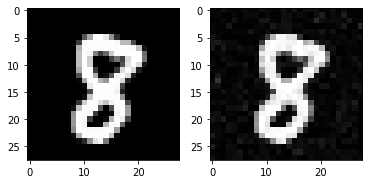

25  :  0.18946970479017317 25
50  :  0.2087584479506157 25
75  :  0.12516028168942017 25
100  :  0.1916961464342647 25
125  :  0.22456023435153927 25
150  :  0.1834864523690125 25
175  :  0.19828267458187 25
200  :  0.20588397733004837 25
225  :  -0.8933647061095968 25
250  :  0.1232914637508542 25
275  :  0.27510567760042254 25
300  :  -0.8933647061095968 25
325  :  0.2195986184886588 25
350  :  -0.8933647061095968 25
375  :  -0.8933647061095968 25
400  :  -0.8924606039177234 25
425  :  -0.885267663961359 25
450  :  -0.8793858639385225 25
475  :  -0.8775048826804749 25
500  :  -0.8775048826804749 25
525  :  -0.8770030979675018 25
550  :  -0.8769901212626362 25
575  :  -0.8769901212626362 25
600  :  -0.8742172760155806 25
625  :  -0.874215261358809 25
650  :  -0.874215261358809 25
675  :  -0.874215261358809 25
700  :  -0.8729111410238821 25
725  :  -0.8724879665451203 25
750  :  -0.8717529421495216 25
775  :  -0.8714481286346558 25
800  :  -0.8708788888374831 25
825  :  -0.870878888837

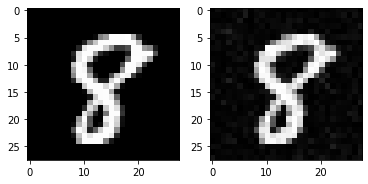

25  :  0.10729959147428919 25
50  :  0.16551812641032482 25
75  :  0.13369398910757024 25
100  :  0.1861962076678546 25
125  :  0.2245065549492039 25
150  :  0.09839227411197965 25
175  :  0.18528201294554458 25
200  :  0.06436752209914443 25
225  :  -0.23706253818560608 25
250  :  0.10388729546869158 25
275  :  0.09899427779365977 25
300  :  0.23459500510445325 25
325  :  0.21206833692749472 25
350  :  0.21008586154801423 25
375  :  0.3146997563789317 25
400  :  0.29636495325617346 25
425  :  0.27194582629469305 25
450  :  0.27961654609737946 25
475  :  0.31221291482976304 25
500  :  0.314621996710909 25
525  :  0.3255292549500049 25
550  :  0.32477654780594506 25
575  :  0.34037840090025734 25
600  :  0.3378428151879695 25
625  :  0.3378428151879695 25
650  :  0.33872142222123736 25
675  :  0.36432879049755945 25
700  :  0.364450142150829 25
725  :  0.3663403099934515 25
750  :  0.36629184085012056 25
775  :  0.36629184085012056 25
800  :  0.36629184085012056 25
825  :  0.36712175740

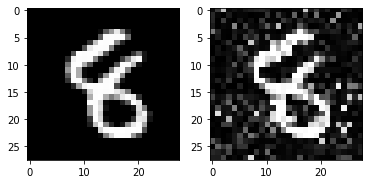

25  :  0.112635135882038 25
50  :  0.18907052728055795 25
75  :  0.20388456420463924 25
100  :  0.11744664553251294 25
125  :  0.07253354834959591 25
150  :  0.05468088532287224 25
175  :  0.10366779820770333 25
200  :  0.10366779820770333 25
225  :  0.12953968954926665 25
250  :  0.14648461771508992 25
275  :  0.24492178624364658 25
300  :  0.251273229787536 25
325  :  0.251273229787536 25
350  :  0.251273229787536 25
375  :  0.27823905956628603 25
400  :  0.2833706831304181 25
425  :  0.2961531484679145 25
450  :  0.2974122544953578 25
475  :  0.297829610314056 25
500  :  0.30092289274334605 25
525  :  0.3037643227115904 25
550  :  0.30486748646163475 25
575  :  0.30788369755762407 25
600  :  0.3117964569949 25
625  :  0.3244330949938514 25
650  :  0.3242454950726939 25
675  :  0.32508965340572027 25
700  :  0.3253422730316859 25
725  :  0.3289588875233906 25
750  :  0.32913756599010496 25
775  :  0.3305293750296822 25
800  :  0.332465619607118 25
825  :  0.33472952151047886 25
850  

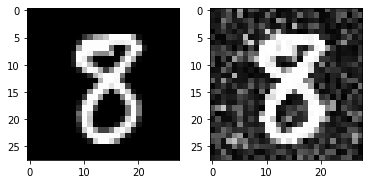

25  :  -0.007199591902156244 25
50  :  0.18274538249676953 25
75  :  0.15090179799166792 25
100  :  0.06015045305543698 25
125  :  0.01690761506299121 25
150  :  0.1405924839574728 25
175  :  0.14894838472117733 25
200  :  0.15108618461856438 25
225  :  0.16890342027892213 25
250  :  0.19958804773896055 25
275  :  0.23599654633040146 25
300  :  0.22203635640487868 25
325  :  0.2501277117016707 25
350  :  0.25071931766909816 25
375  :  0.25419143201829075 25
400  :  0.27027653127762985 25
425  :  0.27027653127762985 25
450  :  0.2706516093391283 25
475  :  0.28992323388222074 25
500  :  0.3199925653581155 25
525  :  0.31868314677420084 25
550  :  0.3262247659389635 25
575  :  0.3272231510305683 25
600  :  0.33133136570601773 25
625  :  0.33133136570601773 25
650  :  0.33977665306508203 25
675  :  0.3420957258317991 25
700  :  0.34152161143013404 25
725  :  0.3457824778200431 25
750  :  0.3482926708280423 25
775  :  0.3504467864884951 25
800  :  0.35647456227104235 25
825  :  0.356634444

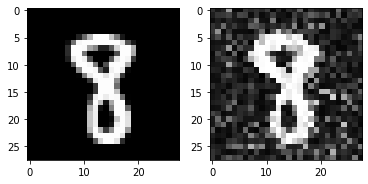

25  :  -0.319439841244257 25
50  :  -0.1621697015284842 25
75  :  -0.15820187404425706 25
100  :  -0.0890303019597618 25
125  :  -0.15100414814884616 25
150  :  -0.055455478603053 25
175  :  -0.056810473810569806 25
200  :  0.019827431132490525 25
225  :  -0.1317424807858104 25
250  :  -0.0536578767848091 25
275  :  0.034868539823158795 25
300  :  0.04058662396469109 25
325  :  0.06918169830734688 25
350  :  0.08214213808919346 25
375  :  0.1614348337425297 25
400  :  0.15147002297426526 25
425  :  0.15147002297426526 25
450  :  0.15147002297426526 25
475  :  0.17464340253271726 25
500  :  0.20032764787993873 25
525  :  0.22116525012719396 25
550  :  0.22116525012719396 25
575  :  0.2237921267500637 25
600  :  0.2415454988997695 25
625  :  0.24852732602635574 25
650  :  0.25252897687911763 25
675  :  0.2712709781809414 25
700  :  0.27469850216774794 25
725  :  0.2760041839764927 25
750  :  0.27894005730725324 25
775  :  0.2906943542576239 25
800  :  0.2906943542576239 25
825  :  0.2919

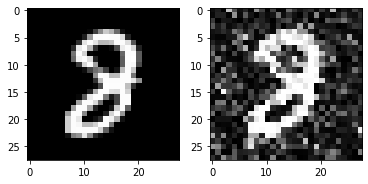

25  :  0.39611627553532264 25
50  :  0.39611627553532264 25
75  :  0.4171585120862708 25
100  :  0.37464228171967173 25
125  :  0.25958368850800584 25
150  :  0.2887207471433588 25
175  :  0.2966003267604151 25
200  :  0.31157245811081635 25
225  :  0.3429479599003989 25
250  :  0.331521978996554 25
275  :  0.33322995618261325 25
300  :  0.334518051210465 25
325  :  0.34838139105380417 25
350  :  0.36389511411667685 25
375  :  0.36101987479246933 25
400  :  0.3670612680111903 25
425  :  0.37020346204908716 25
450  :  0.37148968812201993 25
475  :  0.37313986414602157 25
500  :  0.3735568923998279 25
525  :  0.3768537639607692 25
550  :  0.3809333381946462 25
575  :  0.38289340370433117 25
600  :  0.38468676086944814 25
625  :  0.38550354689390837 25
650  :  0.3876936556638044 25
675  :  0.3875271111538148 25
700  :  0.38905402300919645 25
725  :  0.3899006581276126 25
750  :  0.3905014176345162 25
775  :  0.391135037134697 25
800  :  0.39163918379530105 25
825  :  0.3915543374907628 25

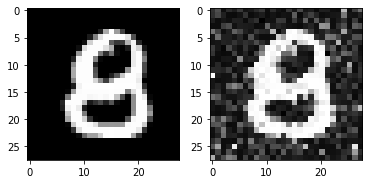

25  :  0.07818079327548155 25
50  :  0.07818079327548155 25
75  :  0.057600339580153204 25
100  :  0.009087072673684804 25
125  :  0.024336706261370855 25
150  :  -0.4915833353776296 25
175  :  -0.9052543307980263 25
200  :  -0.013208743787413324 25
225  :  -0.07119452136850474 25
250  :  -0.4107405762414864 25
275  :  0.015027487776708925 25
300  :  -0.0022568253520304227 25
325  :  -0.9332769348349833 25
350  :  -0.9275113813224052 25
375  :  -0.9260519460669061 25
400  :  -0.9245035805362649 25
425  :  -0.9192309841246052 25
450  :  -0.9178418500069313 25
475  :  -0.9140248729243351 25
500  :  -0.9140248729243351 25
525  :  -0.9140248729243351 25
550  :  -0.9140248729243351 25
575  :  -0.912039253172589 25
600  :  -0.9118516810544894 25
625  :  -0.9111458989694291 25
650  :  -0.9102191010770583 25
675  :  -0.9095902272555347 25
700  :  -0.909079885449606 25
725  :  -0.9088113054139001 25
750  :  -0.9087708458433239 25
775  :  -0.9082971616031705 25
800  :  -0.9080514910830693 25
825

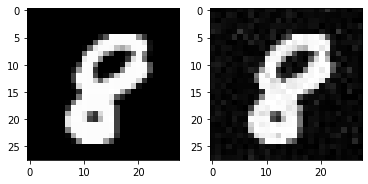

25  :  0.1868790965422299 25
50  :  0.2405890097096608 25
75  :  0.22195996940914098 25
100  :  0.24945044870254773 25
125  :  0.17779916304699594 25
150  :  0.16070849030679368 25
175  :  0.14256054581917255 25
200  :  0.17708296362903764 25
225  :  0.17834757710696147 25
250  :  0.19734831911436634 25
275  :  0.19552899968591186 25
300  :  0.19774961739529673 25
325  :  0.2088766243260889 25
350  :  0.22150235381469663 25
375  :  0.22231310155527617 25
400  :  0.23108935287644894 25
425  :  0.23421342329691075 25
450  :  0.2346706530503787 25
475  :  0.24905284667118732 25
500  :  0.2487192108708538 25
525  :  0.25339292915789635 25
550  :  0.2530441304154427 25
575  :  0.25406885257790557 25
600  :  0.25929885224055016 25
625  :  0.2600456873929379 25
650  :  0.2600877566326377 25
675  :  0.2625845357931471 25
700  :  0.26607136598531245 25
725  :  0.26608032597798104 25
750  :  0.2663288547770788 25
775  :  0.27147587411116636 25
800  :  0.2715558734840998 25
825  :  0.272751598585

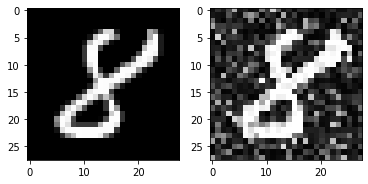

25  :  0.20463368521905667 25
50  :  0.20463368521905667 25
75  :  0.1763182112466009 25
100  :  0.0978981924265131 25
125  :  0.13779789082785587 25
150  :  0.11500602683417882 25
175  :  0.16804456771389847 25
200  :  -0.3037999277606263 25
225  :  -0.887915791360195 25
250  :  -0.8770042792525105 25
275  :  -0.8742463117931065 25
300  :  -0.8732450916126901 25
325  :  -0.8732450916126901 25
350  :  -0.8732450916126901 25
375  :  -0.8732450916126901 25
400  :  -0.8732450916126901 25
425  :  -0.8714192491322846 25
450  :  -0.8714408471649183 25
475  :  -0.8714408471649183 25
500  :  -0.8714408471649183 25
525  :  -0.8714408471649183 25
550  :  -0.8714408471649183 25
575  :  -0.8706669784270127 25
600  :  -0.8685246930531345 25
625  :  -0.8685246930531345 25
650  :  -0.8685246930531345 25
675  :  -0.8684315615973074 25
700  :  -0.8678807254728084 25
725  :  -0.8669928654641811 25
750  :  -0.8666321081921573 25
775  :  -0.865774370958488 25
800  :  -0.865774370958488 25
825  :  -0.86554

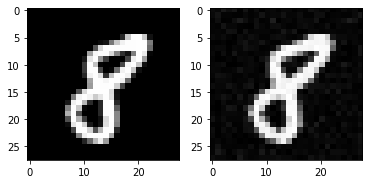

25  :  -0.5679213270584956 25
50  :  -0.5261990619401276 25
75  :  -0.3898159822995778 25
100  :  -0.24059501448036752 25
125  :  -0.11672608281027137 25
150  :  0.08599635576775033 25
175  :  0.30519620710791573 25
200  :  0.3393500834280066 25
225  :  0.30033074238440405 25
250  :  0.293045657384043 25
275  :  0.3238489901146001 25
300  :  0.328058793000531 25
325  :  0.3908204537952064 25
350  :  0.3908204537952064 25
375  :  0.39618348706883544 25
400  :  0.39502247897101483 25
425  :  0.40806190016943983 25
450  :  0.4047465027121908 25
475  :  0.4047465027121908 25
500  :  0.41983595660699474 25
525  :  0.4245312765121192 25
550  :  0.42592012907996324 25
575  :  0.42617203857909614 25
600  :  0.42617203857909614 25
625  :  0.4340083046167145 25
650  :  0.4428148941192707 25
675  :  0.44060740130359044 25
700  :  0.44060740130359044 25
725  :  0.44060740130359044 25
750  :  0.44060740130359044 25
775  :  0.44749965052117024 25
800  :  0.45198365682989683 25
825  :  0.450055724664

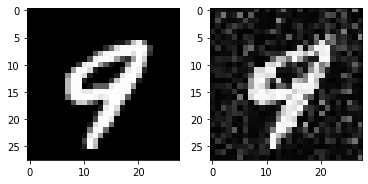

25  :  -0.8822920039658828 25
50  :  -0.8784164569618879 25
75  :  -0.8758720303282832 25
100  :  -0.8683069684427378 25
125  :  -0.8683069684427378 25
150  :  -0.8683069684427378 25
175  :  -0.8651695692470698 25
200  :  -0.8598199079549128 25
225  :  -0.859470080443791 25
250  :  -0.8594169811238682 25
275  :  -0.8577994729597849 25
300  :  -0.8577994729597849 25
325  :  -0.8568027229579072 25
350  :  -0.8567849783243306 25
375  :  -0.8553709444168673 25
400  :  -0.8547523595376713 25
425  :  -0.8541706363176053 25
450  :  -0.8540592830524162 25
475  :  -0.8537334337115544 25
500  :  -0.8533448116477926 25
525  :  -0.8533448116477926 25
550  :  -0.8528952475780668 25
575  :  -0.8526388478047183 25
600  :  -0.8526388478047183 25
625  :  -0.8523981681330896 25
650  :  -0.8523739982082416 25
675  :  -0.8522241356056788 25
700  :  -0.8517733283312248 25
725  :  -0.8516907409386261 25
750  :  -0.8513147124220981 25
775  :  -0.8513208288697869 25
800  :  -0.8511533362740762 25
Time:  78.04

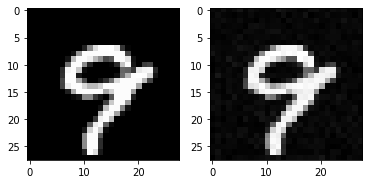

25  :  0.2161983302896986 25
50  :  0.2161983302896986 25
75  :  0.21506705060985232 25
100  :  0.29886944140123967 25
125  :  0.33252603015405136 25
150  :  0.33252603015405136 25
175  :  0.3706821385781967 25
200  :  0.3786400773569102 25
225  :  0.39515418319510126 25
250  :  0.39515418319510126 25
275  :  0.39515418319510126 25
300  :  0.39515418319510126 25
325  :  0.39515418319510126 25
350  :  0.40308199901974995 25
375  :  0.40303275059673566 25
400  :  0.40303275059673566 25
425  :  0.4035993020105481 25
450  :  0.41023538319253744 25
475  :  0.41519639555078475 25
500  :  0.4204661378093855 25
525  :  0.4211299291601914 25
550  :  0.4211299291601914 25
575  :  0.43451012187733895 25
600  :  0.43451012187733895 25
625  :  0.43451012187733895 25
650  :  0.4407129856232232 25
675  :  0.4407129856232232 25
700  :  0.4407129856232232 25
725  :  0.44340787710732654 25
750  :  0.44369394727025296 25
775  :  0.44369394727025296 25
800  :  0.44485040892612665 25
825  :  0.444850408926

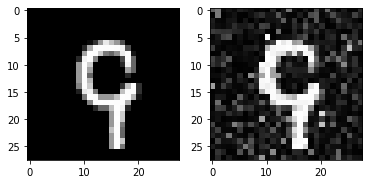

25  :  -0.6059191138884151 25
50  :  -0.5675348334217938 25
75  :  -0.4185655244308344 25
100  :  -0.21336207041690522 25
125  :  -0.0893204809331212 25
150  :  0.23003507091534786 25
175  :  0.30512237673810605 25
200  :  0.3515119219167311 25
225  :  0.3767151761703672 25
250  :  0.38676256683015797 25
275  :  0.40126837997629045 25
300  :  0.4334450419634349 25
325  :  0.4334450419634349 25
350  :  0.4334450419634349 25
375  :  0.4402537369490322 25
400  :  0.4460494489697808 25
425  :  0.4484275440590676 25
450  :  0.44942216963803755 25
475  :  0.46043885749817265 25
500  :  0.46672821524075186 25
525  :  0.46672821524075186 25
550  :  0.47024555189723316 25
575  :  0.47023280024271286 25
600  :  0.47425472381781825 25
625  :  0.47425472381781825 25
650  :  0.47438781474083214 25
675  :  0.47588384473591555 25
700  :  0.47661512452686833 25
725  :  0.4776706507001517 25
750  :  0.47907168861328286 25
775  :  0.47907168861328286 25
800  :  0.47907168861328286 25
825  :  0.479554695

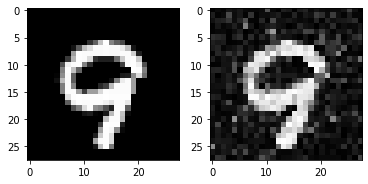

25  :  -0.8006592870340221 25
50  :  -0.7717693506228608 25
75  :  -0.7833217743390797 25
100  :  -0.7026180354416005 25
125  :  -0.7381511868942323 25
150  :  -0.4186248762886404 25
175  :  -0.28311671542296735 25
200  :  -0.1372815657563478 25
225  :  0.15792394598255782 25
250  :  0.2902160538323356 25
275  :  0.31998655432986073 25
300  :  0.3297996275077044 25
325  :  0.3297996275077044 25
350  :  0.3297996275077044 25
375  :  0.3297996275077044 25
400  :  0.3562713474423611 25
425  :  0.35776229340900845 25
450  :  0.35776229340900845 25
475  :  0.35776229340900845 25
500  :  0.3662171744054508 25
525  :  0.3793802226410996 25
550  :  0.38553012134986664 25
575  :  0.3864744298448624 25
600  :  0.3863072560258583 25
625  :  0.40778027740608663 25
650  :  0.40778027740608663 25
675  :  0.40778027740608663 25
700  :  0.4120156259488071 25
725  :  0.4168922660533798 25
750  :  0.42896320637540747 25
775  :  0.42912439872709673 25
800  :  0.42941152523633475 25
825  :  0.441775236650

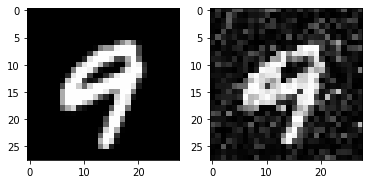

25  :  -0.8257602989893266 25
50  :  -0.8144186013436786 25
75  :  -0.8035777942136231 25
100  :  -0.7966300478682243 25
125  :  -0.7855076182763614 25
150  :  -0.6170960589174223 25
175  :  -0.4049052884259623 25
200  :  -0.34813736898472925 25
225  :  -0.18962783670831976 25
250  :  -0.0844548571232111 25
275  :  0.11910910571489397 25
300  :  0.19924468651614313 25
325  :  0.20423176855769698 25
350  :  0.2259291673603151 25
375  :  0.25442552923619155 25
400  :  0.27169392013290095 25
425  :  0.27169392013290095 25
450  :  0.27169392013290095 25
475  :  0.27169392013290095 25
500  :  0.29084058103764365 25
525  :  0.2951639403686477 25
550  :  0.2951639403686477 25
575  :  0.30631613003619856 25
600  :  0.30710188778914016 25
625  :  0.3078907114128614 25
650  :  0.30891257131264194 25
675  :  0.3197939789266708 25
700  :  0.3198122926307937 25
725  :  0.3198122926307937 25
750  :  0.3221118839634232 25
775  :  0.32445997636835555 25
800  :  0.32643417396911434 25
825  :  0.3272167

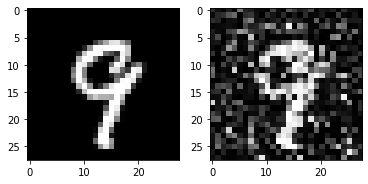

25  :  -0.6580828489851354 25
50  :  -0.5997600132403729 25
75  :  -0.5472647368047054 25
100  :  -0.42116685477395605 25
125  :  -0.27364012728823434 25
150  :  0.1047817639878022 25
175  :  0.12041063089944662 25
200  :  0.1889871331594355 25
225  :  0.22759898319201083 25
250  :  0.25837100885584585 25
275  :  0.2902283180262666 25
300  :  0.38528632179773276 25
325  :  0.3947934638236287 25
350  :  0.40744578760670075 25
375  :  0.4121692324718202 25
400  :  0.4288630267364917 25
425  :  0.4354504825961185 25
450  :  0.43697108838828014 25
475  :  0.44129072714769 25
500  :  0.4556999541042135 25
525  :  0.4556867550703697 25
550  :  0.45746923776629494 25
575  :  0.4625360162243539 25
600  :  0.46417882451135306 25
625  :  0.46460595875369426 25
650  :  0.46651631174957814 25
675  :  0.4722702437698702 25
700  :  0.4769753815158565 25
725  :  0.485187354093546 25
750  :  0.48519330976312447 25
775  :  0.4884816278152995 25
800  :  0.4913830536785425 25
825  :  0.49553127337423963 

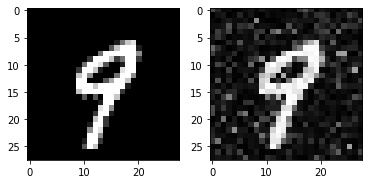

25  :  -0.1405834455527367 25
50  :  0.10379249744592606 25
75  :  0.11232952944861929 25
100  :  0.2546439333158216 25
125  :  0.2988058330313751 25
150  :  0.3522930389135131 25
175  :  0.33315502922724777 25
200  :  0.29101868105005274 25
225  :  0.2636286546804884 25
250  :  0.25248670908460324 25
275  :  0.2793121809168109 25
300  :  0.2845685276161164 25
325  :  0.32442161037852485 25
350  :  0.3776069480078371 25
375  :  0.3558041319532896 25
400  :  0.3541165453379026 25
425  :  0.370004160110058 25
450  :  0.36665911074523366 25
475  :  0.36835664043812116 25
500  :  0.38266395004359416 25
525  :  0.3801120857389182 25
550  :  0.38212613687673 25
575  :  0.3821839310973097 25
600  :  0.3904718596234601 25
625  :  0.3944678033949509 25
650  :  0.403447635633539 25
675  :  0.403447635633539 25
700  :  0.40519150798123615 25
725  :  0.4044373897360389 25
750  :  0.4103342652154553 25
775  :  0.4110610295257941 25
800  :  0.4110610295257941 25
825  :  0.41449183772668696 25
850  :

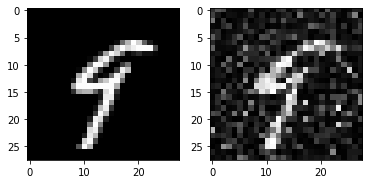

25  :  -0.89277745035354 25
50  :  -0.889629152138433 25
75  :  -0.8850519550910954 25
100  :  -0.881070221514802 25
125  :  -0.8740486080831483 25
150  :  -0.8703038607668027 25
175  :  -0.8702232266327983 25
200  :  -0.8702232266327983 25
225  :  -0.8702232266327983 25
250  :  -0.868888836256542 25
275  :  -0.868878840713833 25
300  :  -0.8682436362122458 25
325  :  -0.8660091982178165 25
350  :  -0.8660091982178165 25
375  :  -0.8660091982178165 25
400  :  -0.86571576837437 25
425  :  -0.8640925273576203 25
450  :  -0.86305452190725 25
475  :  -0.8627775361670031 25
500  :  -0.8624279224222692 25
525  :  -0.8612828040644954 25
550  :  -0.860782450324461 25
575  :  -0.8606949192811363 25
600  :  -0.859734693777419 25
625  :  -0.859734693777419 25
650  :  -0.8593861487905987 25
675  :  -0.8593861964291005 25
700  :  -0.8593861964291005 25
725  :  -0.8586010521514057 25
750  :  -0.8578856184488259 25
775  :  -0.8578856184488259 25
800  :  -0.8578856184488259 25
Time:  69.80454897880554

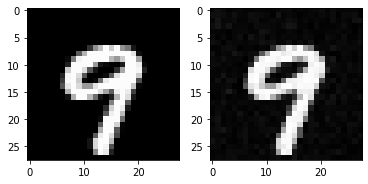

25  :  -0.6783862383338803 25
50  :  -0.45444047680642474 25
75  :  -0.464298564120159 25
100  :  0.08415512721202045 25
125  :  0.31510236403395314 25
150  :  0.38926158582191484 25
175  :  0.3849075735119689 25
200  :  0.41255558386992147 25
225  :  0.4168196113452559 25
250  :  0.4172603447048478 25
275  :  0.4264851367206684 25
300  :  0.4324701891953086 25
325  :  0.44265761093786093 25
350  :  0.45521278161458945 25
375  :  0.4563830021812315 25
400  :  0.4612851420444087 25
425  :  0.46918369777696184 25
450  :  0.46918369777696184 25
475  :  0.4801061123074554 25
500  :  0.48012810067668565 25
525  :  0.4840274727629128 25
550  :  0.48403519398750394 25
575  :  0.48435983495026097 25
600  :  0.4857319671732854 25
625  :  0.48990609810168284 25
650  :  0.4900893312125103 25
675  :  0.4917859775440105 25
700  :  0.4946496488055327 25
725  :  0.49610209591902266 25
750  :  0.49698022448200785 25
775  :  0.49748091410497447 25
800  :  0.4974944289667029 25
825  :  0.497494428966702

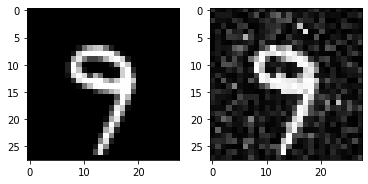

25  :  0.41606340579565615 25
50  :  0.4465476957337716 25
75  :  0.4068142734867305 25
100  :  0.42741419424649274 25
125  :  0.44478830881789383 25
150  :  0.46705769465409935 25
175  :  0.4567905135581676 25
200  :  0.4567905135581676 25
225  :  0.4573484398865929 25
250  :  0.46214100891630266 25
275  :  0.47310105413756764 25
300  :  0.47310105413756764 25
325  :  0.4811082023700708 25
350  :  0.4861252560312035 25
375  :  0.49217535325629175 25
400  :  0.49314735227032536 25
425  :  0.4950926384388559 25
450  :  0.49382360335326775 25
475  :  0.49890478468042554 25
500  :  0.5016480873473022 25
525  :  0.5033902855899257 25
550  :  0.50548074609234 25
575  :  0.5105605052330604 25
600  :  0.5139081276008439 25
625  :  0.514105786777062 25
650  :  0.514467249449994 25
675  :  0.5210920063719675 25
700  :  0.5208398827618392 25
725  :  0.526103891109403 25
750  :  0.526103891109403 25
775  :  0.5279028960322685 25
800  :  0.5292104362083021 25
825  :  0.5292104362083021 25
850  :  

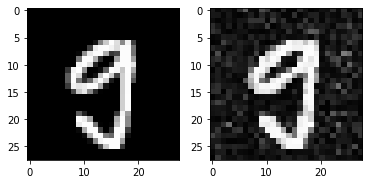

25  :  -0.77806826549944 25
50  :  -0.7618356682061851 25
75  :  -0.7594900462461917 25
100  :  -0.7586260045893134 25
125  :  -0.7538040555011872 25
150  :  -0.6849737998258889 25
175  :  -0.40830462794789824 25
200  :  -0.14091712087969677 25
225  :  0.021827222773643795 25
250  :  0.06659132817885888 25
275  :  0.09376755664986547 25
300  :  0.11351351752815259 25
325  :  0.15876902450781105 25
350  :  0.16289267117401734 25
375  :  0.16300837135572316 25
400  :  0.1815116228630222 25
425  :  0.2167700981750485 25
450  :  0.24198933278847257 25
475  :  0.27405364315215625 25
500  :  0.2756851401629313 25
525  :  0.2892305028872905 25
550  :  0.3103888425471537 25
575  :  0.3180810225779592 25
600  :  0.33012194699096387 25
625  :  0.32945978608952586 25
650  :  0.3374831190847957 25
675  :  0.3408890540385216 25
700  :  0.35791633556048824 25
725  :  0.358985683631272 25
750  :  0.36459974989514865 25
775  :  0.37276722359931136 25
800  :  0.3731565165450638 25
825  :  0.37320786152

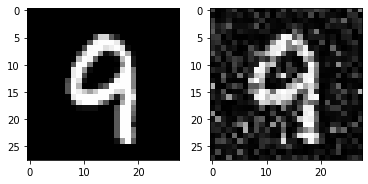

25  :  -0.7362862862054934 25
50  :  -0.7261114949464306 25
75  :  -0.7153001556395748 25
100  :  -0.7110094249739727 25
125  :  -0.67005155248201 25
150  :  -0.637820113950416 25
175  :  -0.5916839751746211 25
200  :  -0.532283265369758 25
225  :  -0.4914987491849904 25
250  :  -0.35557215171205653 25
275  :  -0.08187306364857672 25
300  :  -0.09291663690924723 25
325  :  -0.021696547269134503 25
350  :  -0.006437750708172096 25
375  :  -0.006437750708172096 25
400  :  0.0017106476990484953 25
425  :  0.017931364682504558 25
450  :  0.017931364682504558 25
475  :  0.03905179729939878 25
500  :  0.0679279978598506 25
525  :  0.07392883400464856 25
550  :  0.09912178527356419 25
575  :  0.15585739632477735 25
600  :  0.1656805419966788 25
625  :  0.17636975992054127 25
650  :  0.2014616378391222 25
675  :  0.21027307717357147 25
700  :  0.2130724144394266 25
725  :  0.2389630332371182 25
750  :  0.24240955949781773 25
775  :  0.2676899717205472 25
800  :  0.27102461318689175 25
825  :  

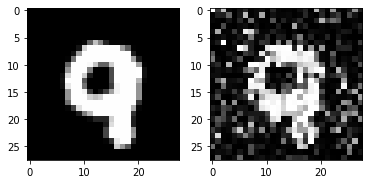

In [22]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28*28) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_rbf_mnist', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [24]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

285.93719244003296
69.80454897880554
136.1142222351498
37.990930034946764


In [25]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1954
800
1174.9285714285713
268.5598918916967


In [26]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

29.418210859335375
10.759342994030252
19.525877381544557
6.464144994000175
